In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count, prepare_df

In [2]:
df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


In [ ]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212], 
    [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619], 
    [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219], 
    [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392], 
    [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189], 
    [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0], 
    [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0], 
    [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204], 
    [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744], 
    [0.12639658719104133, 1.0000000249470075e-10, 20.851108767628933, 3.8694205399833757], 
    [0.1212132957507885, 0.06868421106599219, 9.445203344625348, 100.0], 
    [0.07305173006148806, 0.07305173006148806, 4.686889369376459, 49.86003240187913], 
    [0.07830160011697058, 0.047197607271208426, 7.792050676547918, 100.0], 
    [0.13228889671445893, 0.0854858990969846, 8.857658026221204, 100.0]
    ]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# Load actual survival data
survival_data = {}
ages_data = None  # Initialize to store consistent age bins

for i, sector in enumerate(sector_list):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    survival_data[sector] = survival_fractions
    
    # Use the first sector's ages as reference for all sectors
    if i == 0:
        ages_data = ages

print(f"Using age bins from 0 to {max(ages_data):.1f} years with {len(ages_data)} bins")

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return -np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def reestimate_cluster_params_mle(cluster_sectors):
    """
    Re-estimate parameters by maximizing likelihood on combined cluster data
    """
    # Combine data from all sectors in cluster
    combined_survivors = []
    combined_totals = []
    combined_ages = []
    
    for sector in cluster_sectors:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        
        # Ensure we only use data points where we have observations
        valid_mask = totals > 0
        survivors = survivors[valid_mask]
        totals = totals[valid_mask]
        
        # Use the same age bins for all sectors for consistency
        ages_sector = ages_data[:len(survivors)]  # Trim to match data length
        
        combined_survivors.extend(survivors)
        combined_totals.extend(totals)
        combined_ages.extend(ages_sector)
    
    combined_survivors = np.array(combined_survivors)
    combined_totals = np.array(combined_totals)
    combined_ages = np.array(combined_ages)
    
    # Remove any invalid data points
    valid_idx = (combined_totals > 0) & (combined_survivors >= 0) & (combined_survivors <= combined_totals)
    combined_survivors = combined_survivors[valid_idx]
    combined_totals = combined_totals[valid_idx]
    combined_ages = combined_ages[valid_idx]
    
    if len(combined_survivors) == 0:
        print(f"    Warning: No valid data for cluster {cluster_sectors}")
        return df_params.loc[cluster_sectors].mean().values
    
    # Define objective function
    def neg_log_likelihood(params):
        ll = log_likelihood(params, combined_ages, combined_survivors, combined_totals)
        return -ll if np.isfinite(ll) else 1e10
    
    # Use mean of individual sector parameters as initial guess
    initial_guess = df_params.loc[cluster_sectors].mean().values
    
    # Bounds
    bounds = [(1e-6, 0.3),      # mu_ub
              (1e-6, 0.15),     # mu_lb  
              (0.1, 50.0),     # K
              (0.1, 100.0)]     # m
    
    # Constraints
    constraints = ({'type': 'ineq', 'fun': lambda x: x[0] - x[1]})  # mu_ub >= mu_lb
    
    # Optimize
    result = minimize(neg_log_likelihood, initial_guess, 
                    bounds=bounds, constraints=constraints)
    best_ll = -np.inf
    best_params = initial_guess

    if result.success:
        ll = log_likelihood(result.x, combined_ages, combined_survivors, combined_totals)
        if ll > best_ll:
            best_ll = ll
            best_params = result.x

    
    return best_params

def compute_sector_likelihood(sector, model_params):
    """    
    Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    
    # Use consistent age bins and filter out invalid data
    valid_mask = totals > 0
    survivors = survivors[valid_mask]
    totals = totals[valid_mask]
    ages_sector = ages_data[:len(survivors)]  # Use consistent age bins
    
    if len(survivors) == 0:
        return -np.inf
        
    return log_likelihood(model_params, ages_sector, survivors, totals)

# Generalized iterative clustering algorithm (rest of the code remains the same)
def iterative_likelihood_clustering(survival_data, df_params, n_clusters=2, max_iterations=20, tolerance=1, m_tolerance=0.5):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in range(n_clusters):
        mask = initial_clusters == cluster_id
        if np.sum(mask) > 0:
            cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
        else:
            cluster_params[cluster_id] = df_params.values[np.random.randint(0, n_sectors)]
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"{sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters:")
    for cluster_id, params in cluster_params.items():
        n_in_cluster = np.sum(initial_clusters == cluster_id)
        print(f"  Cluster {cluster_id} ({n_in_cluster} sectors): {params}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                cluster_lls[cluster_id] = compute_sector_likelihood(sector, cluster_params[cluster_id])
            
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters using MLE
        new_cluster_params = {}
        for cluster_id in range(n_clusters):
            mask = new_clusters == cluster_id
            cluster_sectors = [sector_names[i] for i in range(n_sectors) if mask[i]]
            
            if len(cluster_sectors) > 0:
                try:
                    new_cluster_params[cluster_id] = reestimate_cluster_params_mle(cluster_sectors)
                except Exception as e:
                    print(f"  Warning: MLE failed for cluster {cluster_id}: {e}, using mean")
                    new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters:")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): {params}")
        
        # Check convergence with weighted parameter changes
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        # Calculate weighted parameter change - give less weight to m parameter
        param_change = 0
        param_weights = [1.0, 1.0, 1.0, 0.02]  # Less weight on m parameter (index 3)
        
        for cluster_id in range(n_clusters):
            old_params = cluster_params[cluster_id]
            new_params = new_cluster_params[cluster_id]
            
            # Weighted sum of squared differences
            weighted_diff = np.sum([(new_params[i] - old_params[i])**2 * param_weights[i] 
                                  for i in range(4)])
            param_change += weighted_diff/n_clusters
        
        # Also check relative changes for m parameter specifically
        max_m_relative_change = 0
        for cluster_id in range(n_clusters):
            old_m = cluster_params[cluster_id][3]
            new_m = new_cluster_params[cluster_id][3]
            if old_m > 0:
                m_relative_change = abs(new_m - old_m) / old_m
                max_m_relative_change = max(max_m_relative_change, m_relative_change)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Weighted parameter change: {param_change:.6f}")
        print(f"  Max relative m change: {max_m_relative_change:.3f}")
        
        # More tolerant convergence criteria
        m_tolerance = 0.5  # Allow 50% relative change in m parameter
        if (not clusters_changed and 
            param_change < tolerance and 
            max_m_relative_change < m_tolerance):
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Function to compute AIC and BIC for model comparison
def compute_model_selection_criteria(final_clusters, final_params, n_clusters):
    """
    Compute AIC and BIC for the clustering solution
    """
    total_ll = 0
    total_obs = 0
    
    for i, sector in enumerate(sector_list):
        assigned_cluster = final_clusters[i]
        sector_ll = compute_sector_likelihood(sector, final_params[assigned_cluster])
        total_ll += sector_ll
        
        # Count actual observations for this sector
        totals, _ = obtain_total_alive_count(df_analysis, 'Sector', sector)
        total_obs += np.sum(totals > 0)
    
    # Number of parameters: n_clusters * 4 parameters per cluster
    n_params = n_clusters * 4
    
    # AIC and BIC
    AIC = -2 * total_ll + 2 * n_params
    BIC = -2 * total_ll + np.log(total_obs) * n_params
    
    return total_ll, AIC, BIC, n_params

# Run clustering
results = {}
model_comparison = {}

for k in range(2, 15):  # From 2 to 14 clusters
    print(f"\n{'='*60}")
    print(f"RUNNING {k}-CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    final_clusters, final_params, history = iterative_likelihood_clustering(
        survival_data, df_params, n_clusters=k
    )
    
    # Store results
    results[k] = {
        'clusters': final_clusters,
        'params': final_params,
        'history': history
    }
    
    # Compute model selection criteria
    total_ll, AIC, BIC, n_params = compute_model_selection_criteria(final_clusters, final_params, k)
    model_comparison[k] = {
        'log_likelihood': total_ll,
        'AIC': AIC,
        'BIC': BIC,
        'n_params': n_params
    }
    
    print(f"\n{k}-CLUSTER FINAL RESULTS:")
    print(f"Total Log-Likelihood: {total_ll:.2f}")
    print(f"AIC: {AIC:.2f}")
    print(f"BIC: {BIC:.2f}")
    
    print(f"\nFinal cluster parameters:")
    for cluster_id, params in final_params.items():
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
        print(f"  mu_ub: {params[0]:.6f}")
        print(f"  mu_lb: {params[1]:.6f}")
        print(f"  K: {params[2]:.6f}")
        print(f"  m: {params[3]:.6f}")

# Model comparison summary
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame(model_comparison).T
comparison_df.index.name = 'n_clusters'
print(comparison_df)

# Find best model by AIC and BIC
best_aic = comparison_df['AIC'].idxmin()
best_bic = comparison_df['BIC'].idxmin()
best_ll = comparison_df['log_likelihood'].idxmax()

print(f"\nBest model by AIC: {best_aic} clusters")
print(f"Best model by BIC: {best_bic} clusters")
print(f"Best model by Log-Likelihood: {best_ll} clusters")

# for cluster_id in range(best_aic):

#     # Get sectors in this cluster
#     sectors_in_cluster = [sector_list[i] for i, c in enumerate(final_clusters) if c == cluster_id]
#     cluster_params = final_params[cluster_id]

#     # 1. Plot all individual sector survival curves and the cluster survival curve
#     plt.figure(figsize=(8, 6))
#     for sector in sectors_in_cluster:
#         params = df_params.loc[sector].values
#         surv = model_survival_curve_hill(ages_data, *params)
#         plt.plot(ages_data, surv, alpha=0.5, label=f"{sector}", linewidth=1)
#     # Cluster survival curve
#     cluster_surv = model_survival_curve_hill(ages_data, *cluster_params)
#     plt.plot(ages_data, cluster_surv, 'k-', label='Cluster Survival')
#     plt.xlabel("Age")
#     plt.ylabel("Survival Fraction")
#     plt.title(f"Survival Curves: Cluster {cluster_id}")
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.show()

#     # 2. Plot cluster survival curve with observed data points
#     plt.figure(figsize=(8, 6))
#     # Cluster survival curve
#     plt.plot(ages_data, cluster_surv, 'k-', label='Cluster Survival')
#     # Overlay observed data points for all sectors in the cluster
#     for sector in sectors_in_cluster:
#         obs = survival_data[sector]
#         plt.scatter(ages_data, obs, s=10, alpha=0.7, label=f"{sector} data")
#     plt.xlabel("Age")
#     plt.ylabel("Survival Fraction")
#     plt.title(f"Cluster {cluster_id} Survival vs Observed Data")
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.show()

Individual Sector Parameters:
      mu_ub         mu_lb          K           m
G  0.137720  6.036883e-02   9.683528   37.165548
M  0.108534  6.040203e-02  10.324655   20.243102
F  0.082849  7.532170e-02   7.246073   99.999568
J  0.131384  6.388417e-02   9.027011   63.205596
K  0.070120  1.108071e-02  17.599336   11.726783
C  0.099976  4.927069e-02   8.699133  100.000000
H  0.190144  2.801565e-02   6.937674  100.000000
S  0.140572  1.000000e-10  12.954253    5.199080
N  0.123962  1.000000e-10  16.432702    3.676392
I  0.126397  1.000000e-10  20.851109    3.869421
P  0.121213  6.868421e-02   9.445203  100.000000
L  0.073052  7.305173e-02   4.686889   49.860032
Q  0.078302  4.719761e-02   7.792051  100.000000
R  0.132289  8.548590e-02   8.857658  100.000000
Using age bins from 0 to 30.0 years with 150 bins

RUNNING 2-CLUSTER ANALYSIS

Initializing 2-cluster analysis with k-means clustering...
Initial cluster assignments:
  G: Cluster 1
  M: Cluster 1
  F: Cluster 0
  J: Cluster 0
  K: Clu

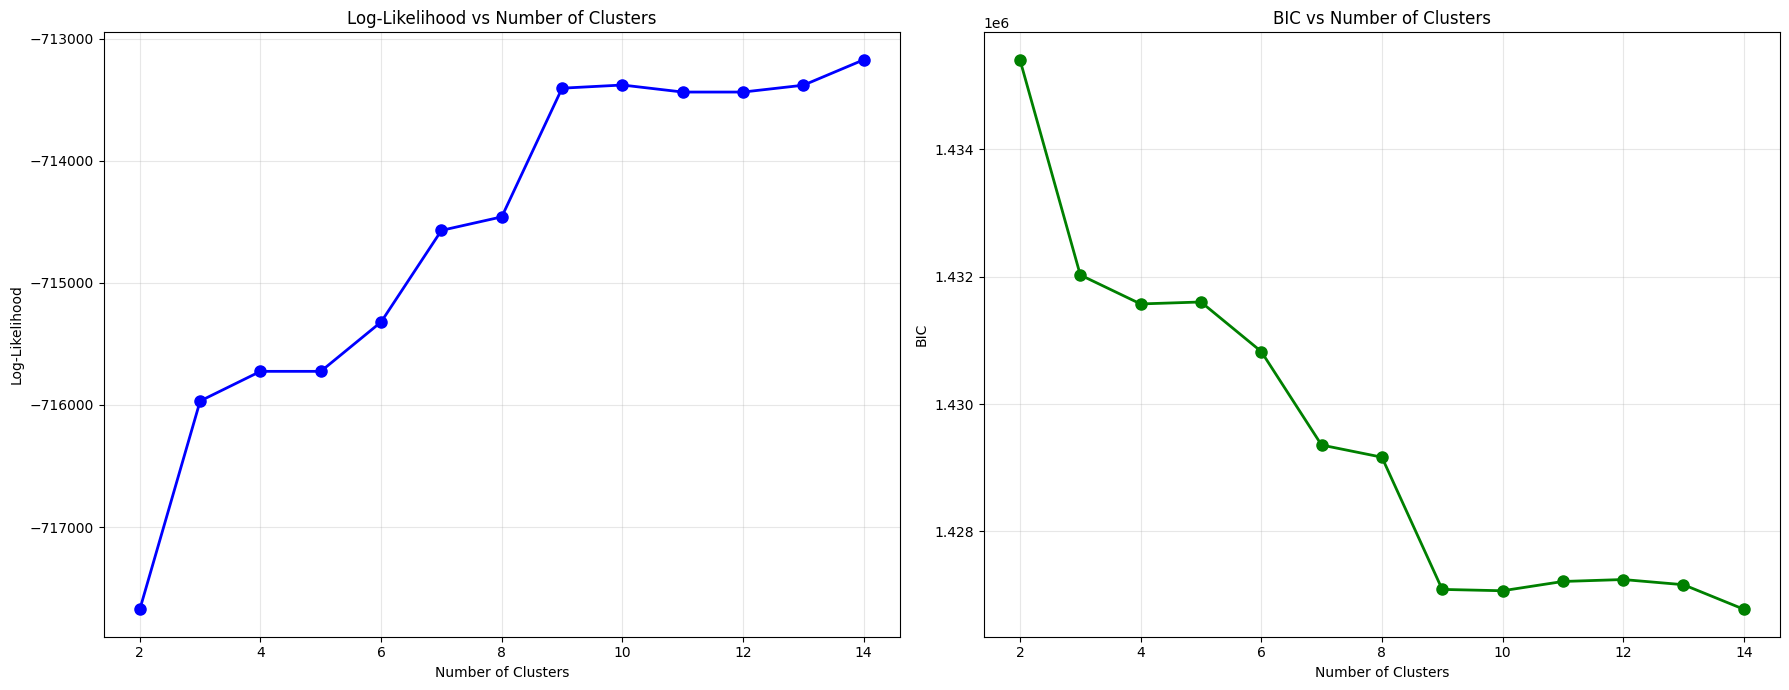

In [6]:
# Plot model comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Log-likelihood
axes[0].plot(comparison_df.index, comparison_df['log_likelihood'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Log-Likelihood')
axes[0].set_title('Log-Likelihood vs Number of Clusters')
axes[0].grid(True, alpha=0.3)

# # AIC
# axes[1].plot(comparison_df.index, comparison_df['AIC'], 'ro-', linewidth=2, markersize=8)
# axes[1].set_xlabel('Number of Clusters')
# axes[1].set_ylabel('AIC')
# axes[1].set_title('AIC vs Number of Clusters (lower is better)')
# axes[1].grid(True, alpha=0.3)

# BIC
axes[1].plot(comparison_df.index, comparison_df['BIC'], 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('BIC')
axes[1].set_title('BIC vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
from scipy.stats import chi2

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212], 
    [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619], 
    [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219], 
    [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392], 
    [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189], 
    [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0], 
    [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0], 
    [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204], 
    [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744], 
    [0.12639658719104133, 1.0000000249470075e-10, 20.851108767628933, 3.8694205399833757], 
    [0.1212132957507885, 0.06868421106599219, 9.445203344625348, 100.0], 
    [0.07305173006148806, 0.07305173006148806, 4.686889369376459, 49.86003240187913], 
    [0.07830160011697058, 0.047197607271208426, 7.792050676547918, 100.0], 
    [0.13228889671445893, 0.0854858990969846, 8.857658026221204, 100.0]
    ]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# Load actual survival data - FIXED: Get consistent ages_data
survival_data = {}
ages_data = None  # Initialize to store consistent age bins

for i, sector in enumerate(sector_list):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    survival_data[sector] = survival_fractions
    
    # Use the first sector's ages as reference for all sectors
    if i == 0:
        ages_data = ages

print(f"Using age bins from 0 to {max(ages_data):.1f} years with {len(ages_data)} bins")

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return -np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def likelihood_ratio_test_between_sectors(sector1, sector2):
    # Get data for each sector
    totals1, survivors1 = obtain_total_alive_count(df_analysis, 'Sector', sector1)
    totals2, survivors2 = obtain_total_alive_count(df_analysis, 'Sector', sector2)
    valid1 = totals1 > 0
    valid2 = totals2 > 0
    ages1 = ages_data[:len(survivors1[valid1])]
    ages2 = ages_data[:len(survivors2[valid2])]

    # H0: Fit both sectors together (4 shared parameters)    
    def neg_logL1(params):
        ll1 = log_likelihood(params[:4], ages1, survivors1[valid1], totals1[valid1])
        ll2 = log_likelihood(params[4:], ages2, survivors2[valid2], totals2[valid2])
        return -(ll1 + ll2)
    # Initial guess: concatenate from df_params
    initial_guess = np.concatenate([df_params.loc[sector1].values, df_params.loc[sector2].values])
    bounds = [(1e-6, 0.3), (1e-10, 0.15), (0.1, 100.0), (0.1, 100.0)] * 2
    constraints = ({'type': 'ineq', 'fun': lambda x: x[0] - x[1]},  # mu_ub >= mu_lb for sector1
                   {'type': 'ineq', 'fun': lambda x: x[4] - x[5]})  # mu_ub >= mu_lb for sector2
    res1 = minimize(neg_logL1, initial_guess, bounds=bounds, constraints = constraints)
    ll1 = -res1.fun

    # H1: Fit each sector separately (8 parameters: 4 per sector)
    combined_ages = np.concatenate([ages1, ages2])
    combined_survivors = np.concatenate([survivors1[valid1], survivors2[valid2]])
    combined_totals = np.concatenate([totals1[valid1], totals2[valid2]])
    def neg_logL2(params):
        return -log_likelihood(params, combined_ages, combined_survivors, combined_totals)
    initial_guess2 = np.mean([df_params.loc[sector1].values, df_params.loc[sector2].values], axis=0)
    bounds2 = [(1e-6, 0.3), (1e-10, 0.15), (0.1, 100.0), (0.1, 100.0)]
    res2 = minimize(neg_logL2, initial_guess2, bounds=bounds2, constraints = ({'type': 'ineq', 'fun': lambda x: x[0] - x[1]}))
    ll2 = -res2.fun

    # Likelihood ratio statistic
    LR = 2 * (ll1 - ll2)
    df = 4  # difference in number of parameters
    p_value = chi2.sf(LR, df)

    # print(f"Sector1: {sector1}, Sector2: {sector2}")
    # print(f"  LogL (separate): {ll1:.2f}")
    # print(f"  LogL (shared):   {ll2:.2f}")
    # print(f"  LR statistic:    {LR:.2f}")
    # print(f"  p-value:         {p_value:.4g}")

    return {
        'sector1': sector1,
        'sector2': sector2,
        'logL_separate': ll1,
        'logL_shared': ll2,
        'LR_stat': LR,
        'df': df,
        'p_value': p_value,
        'params_separate': res1.x,
        'params_shared': res2.x
    }

pval_df = pd.DataFrame(index=sector_list, columns=sector_list, dtype=float)

for i, sector1 in enumerate(sector_list):
    for j, sector2 in enumerate(sector_list):
        if i == j:
            pval_df.loc[sector1, sector2] = np.nan
        elif i < j:
            result = likelihood_ratio_test_between_sectors(sector1, sector2)
            pval_df.loc[sector1, sector2] = round(result['p_value'], 3)
        else:
            pval_df.loc[sector1, sector2] = np.nan

print("Pairwise sector p-values (rounded to 3dp):")
print(pval_df)

Using age bins from 0 to 30.0 years with 150 bins
Pairwise sector p-values (rounded to 3dp):
     G    M    F    J    K    C    H    S    N    I    P    L    Q    R
G  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
M  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
F  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
J  0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
K  0.0  0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
C  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
H  0.0  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0
S  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0
N  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0
I  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0
P  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  0.0
L  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

Individual Sector Parameters:
      mu_ub         mu_lb          K
G  0.136916  5.563612e-02  10.321631
M  0.108310  5.733352e-02  10.862964
F  0.080002  1.000000e-10  29.021702
J  0.130832  5.862652e-02   9.740531
K  0.070124  7.290222e-03  18.089008
C  0.099804  4.803356e-02   8.909684
H  0.192594  2.731861e-02   6.848333
S  0.138544  1.343265e-02  12.389938
N  0.122547  4.203162e-02  12.724066
I  0.124987  5.339180e-02  15.694916
P  0.121186  6.655404e-02   9.749866
L  0.072054  7.205427e-02   6.505126
Q  0.078698  4.703759e-02   7.673004
R  0.132092  8.403562e-02   9.147834

STARTING CLUSTERING ANALYSIS

RUNNING 2-CLUSTER ANALYSIS

Initializing 2-cluster analysis with k-means clustering...
Initial cluster assignments:
  G: Cluster 0
  M: Cluster 0
  F: Cluster 1
  J: Cluster 0
  K: Cluster 0
  C: Cluster 0
  H: Cluster 0
  S: Cluster 0
  N: Cluster 0
  I: Cluster 0
  P: Cluster 0
  L: Cluster 0
  Q: Cluster 0
  R: Cluster 0
Initial cluster parameters (m=5 fixed):
  Cluster 0 (13 se

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1332, mu_lb=0.0587, K=9.3514
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0801, mu_lb=0.0349, K=14.0397
    Final parameters: mu_ub=0.0754, mu_lb=0.0000, K=24.4745
Updated cluster parameters (m=5 fixed):
  Cluster 0 (9 sectors): mu_ub=0.1332, mu_lb=0.0587, K=9.3514
  Cluster 1 (5 sectors): mu_ub=0.0754, mu_lb=0.0000, K=24.4745
  Clusters changed: True
  Parameter change: 22.405473

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-198536.19, LL_1=-218361.09 → Cluster 0
  M: LL_0=-108094.95, LL_1=-110543.16 → Cluster 0
  F: LL_0=-50192.08, LL_1=-47994.52 → Cluster 1
  J: LL_0=-56984.07, LL_1=-61670.77 → Cluster 0
  K: LL_0=-63283.82, LL_1=-56638.17 → Cluster 1
  C: LL_0=-41165.04, LL_1=-39880.30 → Cluster 1
  H: LL_0=-44576.05, LL_1=-51835.16 → Cluster 0
  S: LL_0=-35897.57, LL_1=-39380.48 → Cluster 0
  N: LL_0=-37062.08, LL_1=-39628.48 → Cluster 0
  I: LL_0=-34414.63, LL_1=-37781.12 → Cluster 0
 

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1332, mu_lb=0.0587, K=9.3514
    Re-estimating parameters for sectors: ['F', 'K', 'C', 'L', 'Q']
    Initial guess: mu_ub=0.0801, mu_lb=0.0349, K=14.0397
    Final parameters: mu_ub=0.0754, mu_lb=0.0000, K=24.4744
Updated cluster parameters (m=5 fixed):
  Cluster 0 (9 sectors): mu_ub=0.1332, mu_lb=0.0587, K=9.3514
  Cluster 1 (5 sectors): mu_ub=0.0754, mu_lb=0.0000, K=24.4744
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

2-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -717774.21
AIC: 1435560.42
BIC: 1435594.32

Final cluster assignments:
  G: Cluster 0
  M: Cluster 0
  F: Cluster 1
  J: Cluster 0
  K: Cluster 1
  C: Cluster 1
  H: Cluster 0
  S: Cluster 0
  N: Cluster 0
  I: Cluster 0
  P: Cluster 0
  L: Cluster 1
  Q: Cluster 1
  R: Cluster 0

Final cluster parameters (m=5 fixed):

Cluster 0 (9 sectors): ['G', 'M', 'J', 'H', 'S', 'N', 'I', 'P', 'R']
  mu_ub: 0.133195
  mu_lb: 0.058704
  K: 9.351395
  m: 10.0 (fixed)

Cluster 1 (5 s

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1337, mu_lb=0.0527, K=7.7623
Updated cluster parameters (m=5 fixed):
  Cluster 0 (7 sectors): mu_ub=0.1329, mu_lb=0.0559, K=10.5460
  Cluster 1 (5 sectors): mu_ub=0.0754, mu_lb=0.0000, K=24.4744
  Cluster 2 (2 sectors): mu_ub=0.1337, mu_lb=0.0527, K=7.7623
  Clusters changed: True
  Parameter change: 39.348782

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-198354.15, LL_1=-218361.06, LL_2=-200255.54 → Cluster 0
  M: LL_0=-108437.51, LL_1=-110543.15, LL_2=-107636.54 → Cluster 2
  F: LL_0=-50577.15, LL_1=-47994.52, LL_2=-49410.25 → Cluster 1
  J: LL_0=-57003.23, LL_1=-61670.76, LL_2=-57161.12 → Cluster 0
  K: LL_0=-63888.61, LL_1=-56638.17, LL_2=-61740.83 → Cluster 1
  C: LL_0=-41501.09, LL_1=-39880.30, LL_2=-40339.37 → Cluster 1
  H: LL_0=-44694.98, LL_1=-51835.14, LL_2=-44479.12 → Cluster 2
  S: LL_0=-35878.66, LL_1=-39380.47, LL_2=-36096.72 → Cluster 0
  N: LL_0=-37088.64, LL_1=-39628.47, LL_2=-37190.64 → Cluster 0
  I: LL_0=-34350.76, LL_1

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1337, mu_lb=0.0527, K=7.7623
Updated cluster parameters (m=5 fixed):
  Cluster 0 (7 sectors): mu_ub=0.1329, mu_lb=0.0559, K=10.5460
  Cluster 1 (5 sectors): mu_ub=0.0754, mu_lb=0.0000, K=24.4744
  Cluster 2 (2 sectors): mu_ub=0.1337, mu_lb=0.0527, K=7.7623
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

3-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -717022.01
AIC: 1434062.03
BIC: 1434112.87

Final cluster assignments:
  G: Cluster 0
  M: Cluster 2
  F: Cluster 1
  J: Cluster 0
  K: Cluster 1
  C: Cluster 1
  H: Cluster 2
  S: Cluster 0
  N: Cluster 0
  I: Cluster 0
  P: Cluster 0
  L: Cluster 1
  Q: Cluster 1
  R: Cluster 0

Final cluster parameters (m=5 fixed):

Cluster 0 (7 sectors): ['G', 'J', 'S', 'N', 'I', 'P', 'R']
  mu_ub: 0.132942
  mu_lb: 0.055898
  K: 10.546013
  m: 10.0 (fixed)

Cluster 1 (5 sectors): ['F', 'K', 'C', 'L', 'Q']
  mu_ub: 0.075356
  mu_lb: 0.000000
  K: 24.474406
  m: 10.0 (fixed)

Cluster 2 (2 sectors): ['M

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1401, mu_lb=0.0573, K=9.1938
    Re-estimating parameters for sectors: ['F', 'K', 'L', 'Q']
    Initial guess: mu_ub=0.0752, mu_lb=0.0316, K=15.3222
    Final parameters: mu_ub=0.0732, mu_lb=0.0000, K=25.9094
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8631
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
Updated cluster parameters (m=5 fixed):
  Cluster 0 (8 sectors): mu_ub=0.1401, mu_lb=0.0573, K=9.1938
  Cluster 1 (4 sectors): mu_ub=0.0732, mu_lb=0.0000, K=25.9094
  Cluster 2 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8631
  Cluster 3 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Clusters changed: True
  Parameter change: 51.304859

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-198381.06, LL_1=-220395.84

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1414, mu_lb=0.0566, K=9.1714
    Re-estimating parameters for sectors: ['F', 'K', 'L', 'Q']
    Initial guess: mu_ub=0.0752, mu_lb=0.0316, K=15.3222
    Final parameters: mu_ub=0.0732, mu_lb=0.0000, K=25.9094
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1147, mu_lb=0.0619, K=10.3064


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1108, mu_lb=0.0592, K=10.5736
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
Updated cluster parameters (m=5 fixed):
  Cluster 0 (7 sectors): mu_ub=0.1414, mu_lb=0.0566, K=9.1714
  Cluster 1 (4 sectors): mu_ub=0.0732, mu_lb=0.0000, K=25.9094
  Cluster 2 (2 sectors): mu_ub=0.1108, mu_lb=0.0592, K=10.5736
  Cluster 3 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Clusters changed: True
  Parameter change: 0.084289

--- Iteration 3 ---
Likelihood-based assignments:
  G: LL_0=-198385.31, LL_1=-220395.84, LL_2=-201238.08, LL_3=-209465.34 → Cluster 0
  M: LL_0=-108887.42, LL_1=-111207.61, LL_2=-106912.60, LL_3=-107962.27 → Cluster 2
  F: LL_0=-50816.73, LL_1=-48046.36, LL_2=-48737.08, LL_3=-48229.30 → Cluster 1
  J: LL_0=-57062.21, LL_1=-62204.15, LL_2=-57434.74, LL_3=-58972.47 → Cluster 0
  K: LL_0=-64499.46, LL_1=-56570.28, LL_2=-60160.42, LL_3=-57785.81 → Cluster 1
  C: LL_0=-41565.63, LL_1=-39962.63, LL_2=-40196.38, LL_3=-39540.00 → Cluster 3
  H: LL_0=-44233.73, LL_1=-52408.69, LL_2=-46139.92, LL_3=

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1414, mu_lb=0.0567, K=9.1713
    Re-estimating parameters for sectors: ['F', 'K', 'L', 'Q']
    Initial guess: mu_ub=0.0752, mu_lb=0.0316, K=15.3222
    Final parameters: mu_ub=0.0732, mu_lb=0.0000, K=25.9094
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1147, mu_lb=0.0619, K=10.3064


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1108, mu_lb=0.0592, K=10.5737
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
Updated cluster parameters (m=5 fixed):
  Cluster 0 (7 sectors): mu_ub=0.1414, mu_lb=0.0567, K=9.1713
  Cluster 1 (4 sectors): mu_ub=0.0732, mu_lb=0.0000, K=25.9094
  Cluster 2 (2 sectors): mu_ub=0.1108, mu_lb=0.0592, K=10.5737
  Cluster 3 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

4-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -715858.70
AIC: 1431741.40
BIC: 1431809.19

Final cluster assignments:
  G: Cluster 0
  M: Cluster 2
  F: Cluster 1
  J: Cluster 0
  K: Cluster 1
  C: Cluster 3
  H: Cluster 0
  S: Cluster 0
  N: Cluster 0
  I: Cluster 0
  P: Cluster 2
  L: Cluster 1
  Q: Cluster 1
  R: Cluster 0

Final cluster parameters (m=5 fixed):

Cluster 0 (7 sectors): ['G', 'J', 'H', 'S', 'N', 'I', 'R']
  mu_ub: 0.141367
  mu_lb: 0.056650
  K: 9.171344
  m: 10.0 (fixed)

Cluster 1 (4 sectors): ['F', 'K', 'L', 'Q']
  mu_ub: 0.073171
  mu_lb: 0.000000
  K:

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1246, mu_lb=0.0622, K=10.2057
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S', 'I']
    Initial guess: mu_ub=0.1448, mu_lb=0.0417, K=10.9991


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1429, mu_lb=0.0561, K=9.1144
Updated cluster parameters (m=5 fixed):
  Cluster 0 (4 sectors): mu_ub=0.0732, mu_lb=0.0000, K=25.9094
  Cluster 1 (3 sectors): mu_ub=0.1246, mu_lb=0.0622, K=10.2057
  Cluster 2 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8630
  Cluster 3 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 4 (5 sectors): mu_ub=0.1429, mu_lb=0.0561, K=9.1144
  Clusters changed: True
  Parameter change: 61.675392

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-220395.84, LL_1=-198840.39, LL_2=-201906.78, LL_3=-209465.34, LL_4=-198401.85 → Cluster 4
  M: LL_0=-111207.61, LL_1=-107628.70, LL_2=-106894.64, LL_3=-107962.27, LL_4=-109035.39 → Cluster 2
  F: LL_0=-48046.36, LL_1=-49825.29, LL_2=-48596.58, LL_3=-48229.30, LL_4=-50918.66 → Cluster 0
  J: LL_0=-62204.15, LL_1=-57010.63, LL_2=-57573.21, LL_3=-58972.47, LL_4=-57086.91 → Cluster 1
  K: LL_0=-56570.28, LL_1=-62484.88, LL_2=-59785.29, LL_3=-57785.81, LL_4=-64699.53 → Cl

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1273, mu_lb=0.0623, K=10.3786
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8631
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['G', 'H', 'S', 'R']
    Initial guess: mu_ub=0.1500, mu_lb=0.0451, K=9.6769
    Final parameters: mu_ub=0.1478, mu_lb=0.0540, K=8.7952
Updated cluster parameters (m=5 fixed):
  Cluster 0 (4 sectors): mu_ub=0.0732, mu_lb=0.0000, K=25.9094
  Cluster 1 (4 sectors): mu_ub=0.1273, mu_lb=0.0623, K=10.3786
  Cluster 2 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8631
  Cluster 3 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 4 (4 sectors): mu_ub=0.1478, mu_lb=0.0540, K=8.7952
  Clusters changed: True
  Parameter change: 0.131798

--- Iteration 3 ---
Likeli

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1276, mu_lb=0.0640, K=10.2503
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8631
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1560, mu_lb=0.0321, K=9.8533
    Final parameters: mu_ub=0.1482, mu_lb=0.0533, K=8.7852
Updated cluster parameters (m=5 fixed):
  Cluster 0 (4 sectors): mu_ub=0.0732, mu_lb=0.0000, K=25.9094
  Cluster 1 (5 sectors): mu_ub=0.1276, mu_lb=0.0640, K=10.2503
  Cluster 2 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8631
  Cluster 3 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 4 (3 sectors): mu_ub=0.1482, mu_lb=0.0533, K=8.7852
  Clusters changed: True
  Parameter change: 0.016554

--- Iteration 4 ---
Likelihood-

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1276, mu_lb=0.0640, K=10.2503
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1560, mu_lb=0.0321, K=9.8533
    Final parameters: mu_ub=0.1482, mu_lb=0.0533, K=8.7852
Updated cluster parameters (m=5 fixed):
  Cluster 0 (4 sectors): mu_ub=0.0732, mu_lb=0.0000, K=25.9094
  Cluster 1 (5 sectors): mu_ub=0.1276, mu_lb=0.0640, K=10.2503
  Cluster 2 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8630
  Cluster 3 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 4 (3 sectors): mu_ub=0.1482, mu_lb=0.0533, K=8.7852
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

5-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -715463.49
AIC: 1430956.98
BIC: 1431041.73

Final cluster assignments:
  G: Cluster 4
  M: Cluster 2
  F: Cluster 0
  J: Cluster 1
  

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1134, mu_lb=0.0584, K=10.8125
    Re-estimating parameters for sectors: ['F', 'L']
    Initial guess: mu_ub=0.0760, mu_lb=0.0360, K=17.7634
    Final parameters: mu_ub=0.0789, mu_lb=0.0000, K=28.4267
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S']
    Initial guess: mu_ub=0.1497, mu_lb=0.0388, K=9.8251
    Final parameters: mu_ub=0.1446, mu_lb=0.0543, K=8.9691
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6697
Updated cluster parameters (m=5 fixed):
  Cluster 0 (2 sectors): mu_ub=0.0707, mu_lb=0.0236, K=15.9056
  Cluster 1 (3 sectors): mu_ub=0.1134, mu_lb=0.0584, K=10.8125
  Cluster 2 (2 sectors): mu_ub=0.0789, mu_lb=0.0000, K=28.4267
  Cluster 3 (1 sectors): mu_ub

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['G', 'J', 'H', 'S']
    Initial guess: mu_ub=0.1497, mu_lb=0.0388, K=9.8251


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1446, mu_lb=0.0543, K=8.9691
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6698
Updated cluster parameters (m=5 fixed):
  Cluster 0 (2 sectors): mu_ub=0.0707, mu_lb=0.0236, K=15.9056
  Cluster 1 (3 sectors): mu_ub=0.1134, mu_lb=0.0584, K=10.8125
  Cluster 2 (2 sectors): mu_ub=0.0789, mu_lb=0.0000, K=28.4267
  Cluster 3 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 4 (4 sectors): mu_ub=0.1446, mu_lb=0.0543, K=8.9691
  Cluster 5 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6698
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

6-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -715054.19
AIC: 1430144.38
BIC: 1430246.08

Final cluster assignments:
  G: Cluster 4
  M: Cluster 1
  F: Cluster 2
  J: Cluster 4
  K: Cluster 0
  C: Cluster 3
  H: Cluster 4
  S: Cluster 4
  N: Cluster 1
  I: Cluster 5
  P: Cluster 1
 

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1108, mu_lb=0.0592, K=10.5737
    Re-estimating parameters for sectors: ['K', 'Q']
    Initial guess: mu_ub=0.0744, mu_lb=0.0272, K=12.8810
    Final parameters: mu_ub=0.0707, mu_lb=0.0236, K=15.9057
    Re-estimating parameters for sectors: ['F', 'L']
    Initial guess: mu_ub=0.0760, mu_lb=0.0360, K=17.7634
    Final parameters: mu_ub=0.0789, mu_lb=0.0000, K=28.4268
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1560, mu_lb=0.0321, K=9.8533
    Final parameters: mu_ub=0.1482, mu_lb=0.0533, K=8.7852
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['J', 'N']
    Initial guess: mu_ub=0.1267, mu_lb=0.0503, K=11.2323
    Final parameters: mu_ub=0.1290, mu_lb=0.0562, K=10.1246
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6700
Updated cluster parameters (m=5 fixed):
  Cluster 0 (2 sectors): mu_ub=0.1108, mu_lb=0.0592, K=10.5737
  Cluster 1 (2 sectors): mu_ub=0.0707, mu_lb=0.0236, K=15.9057
  Cluster 2 (2 sectors): mu_ub=0.0789, mu_lb=0.0000, K=28.4268
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0533, K=8.7852
  Cluster 4 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 5 (2 sectors): mu_ub=0.1290, mu_lb=0.0562, K=10.1246
  Cluster 6 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6700
  Clusters changed: True
  Parameter change: 40.790115

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-201238.06, LL_1=-229610.74, LL_2=-214216.18, LL_3=-198556.94, LL_4=-209465.34, LL_5=-198636.76, LL_6=-199011.77 → Cluster 3
  M: LL_0=-106912.60, LL_1=-113543.89, LL_2=-109485.86, LL_3=-109438.39, LL_4=-107962.27, LL_5=-107866.73, LL_6=-108925.18 → Cluster 0
  F: LL_0=-48737.08, LL_1=-49410.67, LL_2=-47789.29, LL_3=-51140.33, LL_4=-48229.30, 

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['J', 'N', 'P']
    Initial guess: mu_ub=0.1249, mu_lb=0.0557, K=10.7382


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1274, mu_lb=0.0589, K=9.9602
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6697
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8631
  Cluster 1 (2 sectors): mu_ub=0.0707, mu_lb=0.0236, K=15.9055
  Cluster 2 (2 sectors): mu_ub=0.0789, mu_lb=0.0000, K=28.4270
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0533, K=8.7852
  Cluster 4 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 5 (3 sectors): mu_ub=0.1274, mu_lb=0.0589, K=9.9602
  Cluster 6 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6697
  Clusters changed: True
  Parameter change: 0.110789

--- Iteration 3 ---
Likelihood-based assignments:
  G: LL_0=-201906.78, LL_1=-229610.75, LL_2=-214216.16, LL_3=-198556.94, LL_4=-209465.34, LL_5=-198739.31, LL_6=-199011.79 → Cluster 3
  M: LL_0=-106894.64, LL_1=-113543.89, LL_2=-109485.8

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0701, mu_lb=0.0073, K=18.0887
    Re-estimating parameters for sectors: ['M', 'P']
    Initial guess: mu_ub=0.1147, mu_lb=0.0619, K=10.3064
    Final parameters: mu_ub=0.1108, mu_lb=0.0592, K=10.5736
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6697
    Re-estimating parameters for sectors: ['J', 'N']
    Initial guess: mu_ub=0.1267, mu_lb=0.0503, K=11.2323
    Final parameters: mu_ub=0.1290, mu_lb=0.0562, K=10.1246
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.0787, mu_lb=0.0470, K=7.6731
  Cluster 1 (2 sectors): mu_ub=0.0789, mu_lb=0.0000, K=28.4271
  Cluster 2 (3 sectors): mu_ub=0.1482, mu_lb=0.0533, K=8.7852
  Cluster 3 (1 sectors): mu_ub=0.0701, m

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1482, mu_lb=0.0533, K=8.7852
    Re-estimating parameters for sectors: ['K']
    Initial guess: mu_ub=0.0701, mu_lb=0.0073, K=18.0890
    Final parameters: mu_ub=0.0701, mu_lb=0.0073, K=18.0889
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8631
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6699
    Re-estimating parameters for sectors: ['J', 'N', 'P']
    Initial guess: mu_ub=0.1249, mu_lb=0.0557, K=10.7382
    Final parameters: mu_ub=0.1274, mu_lb=0.0589, K=9.9602
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.0787, mu_lb=0.0470, K=7.6730
  

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1290, mu_lb=0.0562, K=10.1246
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8630
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0886
  Cluster 2 (2 sectors): mu_ub=0.0789, mu_lb=0.0000, K=28.4269
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0533, K=8.7852
  Cluster 4 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 5 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6698
  Cluster 6 (1 sectors): mu_ub=0.1212, mu_lb=0.0666, K=9.7499
  Cluster 7 (1 sectors): mu_ub=0.0787, mu_lb=0.0470, K=7.6732
  Cluster 8 (2 sectors): mu_ub=0.1290, mu_lb=0.0562, K=10.1246
  Clusters changed: True
  Parameter change: 39.988882

--- Iteration 2 ---
Likelihood-based assignments:
  G: LL_0=-201906.77, LL_1=-230063.12, LL_2=-214216.14, LL_3=-198556.94, LL_4=-209465.34, LL_5=-199011.78, LL_6=-199255.47, LL_7=-227787.35, LL_8=-198636.77 → Cluster 3
  M: LL_0=-106894.64, LL_1=-113646.76, LL_2=-109485.85, LL_3=-

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['K']
    Initial guess: mu_ub=0.0701, mu_lb=0.0073, K=18.0890
    Final parameters: mu_ub=0.0701, mu_lb=0.0073, K=18.0886
    Re-estimating parameters for sectors: ['F', 'L']
    Initial guess: mu_ub=0.0760, mu_lb=0.0360, K=17.7634
    Final parameters: mu_ub=0.0789, mu_lb=0.0000, K=28.4267
    Re-estimating parameters for sectors: ['G', 'H', 'S']
    Initial guess: mu_ub=0.1560, mu_lb=0.0321, K=9.8533
    Final parameters: mu_ub=0.1482, mu_lb=0.0533, K=8.7852
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6698
    Re-estimating parameters for sectors: ['P']
    Initial guess: mu_ub=0.1212, mu_lb=0.0666, K=9.

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1212, mu_lb=0.0666, K=9.7499
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6732
    Re-estimating parameters for sectors: ['J', 'N']
    Initial guess: mu_ub=0.1267, mu_lb=0.0503, K=11.2323
    Final parameters: mu_ub=0.1290, mu_lb=0.0562, K=10.1246
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8630
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0886
  Cluster 2 (2 sectors): mu_ub=0.0789, mu_lb=0.0000, K=28.4267
  Cluster 3 (3 sectors): mu_ub=0.1482, mu_lb=0.0533, K=8.7852
  Cluster 4 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 5 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6698
  Cluster 6 (1 sectors): mu_ub=0.1212, mu_lb=0.0666, K=9.7499
  Cluster 7 (1 sectors): mu_ub=0.0787, mu_lb=0.0470, K=7.6732
  Cluster 8 (2 sectors): mu_ub=0.1290, mu_lb=0.0562, K=10.1246
  Clu

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0701, mu_lb=0.0073, K=18.0886
    Re-estimating parameters for sectors: ['F', 'L']
    Initial guess: mu_ub=0.0760, mu_lb=0.0360, K=17.7634
    Final parameters: mu_ub=0.0789, mu_lb=0.0000, K=28.4267
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Re-estimating parameters for sectors: ['C']
    Initial guess: mu_ub=0.0998, mu_lb=0.0480, K=8.9097


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6699
    Re-estimating parameters for sectors: ['G', 'H']
    Initial guess: mu_ub=0.1648, mu_lb=0.0415, K=8.5850
    Final parameters: mu_ub=0.1490, mu_lb=0.0555, K=8.5650
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6731
    Re-estimating parameters for sectors: ['J', 'N', 'P']
    Initial guess: mu_ub=0.1249, mu_lb=0.0557, K=10.7382
    Final parameters: mu_ub=0.1274, mu_lb=0.0589, K=9.9602
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1159, mu_lb=0.0660, K=9.0288

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0812, mu_lb=0.0000, K=24.4123
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6697
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6731
    Re-estimating parameters for sectors: ['J', 'N', 'P']
    Initial guess: mu_ub=0.1249, mu_lb=0.0557, K=10.7382


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1274, mu_lb=0.0589, K=9.9602
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['L']
    Initial guess: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Attempt 1: Failed - Inequality constraints incompatible
    Attempt 2: Failed - Inequality constraints incompatible
    Final parameters: mu_ub=0.0729, mu_lb=0.0725, K=7.8177
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1159, mu_lb=0.0660, K=9.0288
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0886
  Cluster 2 (2 sectors): mu_ub=0.0812, mu_lb=0.0000, K=24.4123
  Cluster 3 (1 sectors): mu_ub=0.1385, mu_lb=0.0134, K=12.3899
  Cluster 4 (1 sectors): mu_ub=0.1926, mu_lb=0.0273, K=6.8483
  Cluster 5 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6697
  Cluster 6 (1 sectors): mu_ub=0.1369, mu_lb=0.0556, K=10.3216
  Cluster 7 (1

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0812, mu_lb=0.0000, K=24.4124
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6697
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Re-estimating parameters for sectors: ['J', 'N', 'P']
    Initial guess: mu_ub=0.1249, mu_lb=0.0557, K=10.7382

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1274, mu_lb=0.0589, K=9.9602
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['L']
    Initial guess: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Attempt 1: Failed - Inequality constraints incompatible
    Attempt 2: Failed - Inequality constraints incompatible
    Final parameters: mu_ub=0.0731, mu_lb=0.0721, K=8.0315
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1159, mu_lb=0.0660, K=9.0288
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0889
  Cluster 2 (2 sectors): mu_ub=0.0812, mu_lb=0.0000, K=24.4124
  Cluster 3 (1 sectors): mu_ub=0.1385, mu_lb=0.0134, K=12.3899
  Cluster 4 (1 sectors): mu_ub=0.1926, mu_lb=0.0273, K=6.8483
  Cluster 5 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6697
  Cluster 6 (1 sectors): mu_ub=0.1369, mu_lb=0.0556, K=10.3216
  Cluster 7 (1

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0812, mu_lb=0.0000, K=24.4124
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6699
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6732
    Re-estimating parameters for sectors: ['J', 'N', 'P']
    Initial guess: mu_ub=0.1249, mu_lb=0.0557, K=10.7382


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1274, mu_lb=0.0589, K=9.9602
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['L']
    Initial guess: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Attempt 1: Failed - Inequality constraints incompatible
    Attempt 3: Failed - Inequality constraints incompatible
    Final parameters: mu_ub=0.0727, mu_lb=0.0727, K=6.5372
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1159, mu_lb=0.0660, K=9.0288
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0886
  Cluster 2 (2 sectors): mu_ub=0.0812, mu_lb=0.0000, K=24.4124
  Cluster 3 (1 sectors): mu_ub=0.1385, mu_lb=0.0134, K=12.3899
  Cluster 4 (1 sectors): mu_ub=0.1926, mu_lb=0.0273, K=6.8483
  Cluster 5 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6699
  Cluster 6 (1 sectors): mu_ub=0.1369, mu_lb=0.0556, K=10.3216
  Cluster 7 (1

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0812, mu_lb=0.0000, K=24.4123
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3899


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6698
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6731
    Re-estimating parameters for sectors: ['J', 'N', 'P']
    Initial guess: mu_ub=0.1249, mu_lb=0.0557, K=10.7382
    Final parameters: mu_ub=0.1274, mu_lb=0.0589, K=9.9602
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['L']
    Initial guess: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Attempt 1: Failed - Inequality constraints incompatible
    Attempt 2: Failed - Inequality constraints incompatible
    Attempt 3: Failed - Inequality constraints incompatible
    Final parameters: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1159, mu_lb=0.0660, K=9.0288
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0888
  Cluster 2 (2 sectors): mu_ub=0.0812, mu_lb=0.0000, K=24.4123
  Cluster 3 (1 sectors): mu_ub=0.1385, mu_lb=0.0134, K=12.3899
  Cluster 4 (1 sectors): mu_ub=0.1926, mu_lb=0.0273, K=6.8483
  Cluster 5 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6698
  Cluster 6 (1 sectors): mu_ub=0.1369, mu_lb=0.0556, K=10.3216
  Cluster 7 (1 sectors): mu_ub=0.0787, mu_lb=0.0470, K=7.6731
  Cluster 8 (3 sectors): mu_ub=0.1274, mu_lb=0.0589, K=9

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0812, mu_lb=0.0000, K=24.4123
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6698
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6732
    Re-estimating parameters for sectors: ['J', 'N', 'P']
    Initial guess: mu_ub=0.1249, mu_lb=0.0557, K=10.7382
    Final parameters: mu_ub=0.1274, mu_lb=0.0589, K=9.9602
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['L']
    Initial guess: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Attempt 1: Failed - Inequality constraints incompatible
    Attempt 2: Failed - Inequality constraints incompatible
    Final parameters: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1159, mu_lb=0.0660, K=9.0288
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0886
  Cluster 2 (2 sectors): mu_ub=0.0812, mu_lb=0.0000, K=24.4123
  Cluster 3 (1 sectors): mu_ub=0.1385, mu_lb=0.0134, K=12.3899
  Cluster 4 (1 sectors): mu_

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0812, mu_lb=0.0000, K=24.4124
    Re-estimating parameters for sectors: ['N']
    Initial guess: mu_ub=0.1225, mu_lb=0.0420, K=12.7241
    Final parameters: mu_ub=0.1225, mu_lb=0.0420, K=12.7242
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6697
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Re-estimating parameters for sectors: ['J', 'P']
    Initial guess: mu_ub=0.1260, mu_lb=0.0626, K=9.7452
    Final parameters: mu_ub=0.1281, mu_lb=0.0615, K=9.6152
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['L']
    Initial guess: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Attempt 1: Failed - Inequality constraints incompatible
    Attempt 3: Failed - Inequality constraints incompatible
    Final parameters: mu_ub=0.0727, mu_lb=0.0727, K=7.7530
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0812, mu_lb=0.0000, K=24.4124
    Re-estimating parameters for sectors: ['N']
    Initial guess: mu_ub=0.1225, mu_lb=0.0420, K=12.7241
    Final parameters: mu_ub=0.1225, mu_lb=0.0420, K=12.7235
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6699
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6731
    Re-estimating parameters for sectors: ['J', 'P']
    Initial guess: mu_ub=0.1260, mu_lb=0.0626, K=9.7452


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1281, mu_lb=0.0615, K=9.6152
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['L']
    Initial guess: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Attempt 1: Failed - Inequality constraints incompatible
    Attempt 2: Failed - Inequality constraints incompatible
    Attempt 3: Failed - Inequality constraints incompatible
    Final parameters: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1159, mu_lb=0.0660, K=9.0288
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0888
  Cluster 2 (2 sectors): mu_ub=0.0812, mu_lb=0.0000, K=24.4124
  Cluster 3 (1 sectors): mu_ub=0.1225, mu_lb=0.0420, K=12.7235
  Cluster 4 (1 sectors): mu_ub=0.1926, mu_lb=0.0273, K=6.8483
  Cluster 5 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6699
  Cluster 6 (1 s

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0902, mu_lb=0.0637, K=8.2472
    Re-estimating parameters for sectors: ['N']
    Initial guess: mu_ub=0.1225, mu_lb=0.0420, K=12.7241


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1225, mu_lb=0.0420, K=12.7239
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6697
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Re-estimating parameters for sectors: ['J', 'P']
    Initial guess: mu_ub=0.1260, mu_lb=0.0626, K=9.7452
    Final parameters: mu_ub=0.1281, mu_lb=0.0615, K=9.6153
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Fi

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0812, mu_lb=0.0000, K=24.4124
    Re-estimating parameters for sectors: ['N']
    Initial guess: mu_ub=0.1225, mu_lb=0.0420, K=12.7241
    Final parameters: mu_ub=0.1225, mu_lb=0.0420, K=12.7238
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6698
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6731
    Re-estimating parameters for sectors: ['J', 'P']
    Initial guess: mu_ub=0.1260, mu_lb=0.0626, K=9.7452
    Final parameters: mu_ub=0.1281, mu_lb=0.0615, K=9.6152
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['L']
    Initial guess: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Attempt 1: Failed - Inequality constraints incompatible
    Attempt 2: Failed - Inequality constraints incompatible
    Attempt 3: Failed - Inequality constraints incompatible
    Final parameters: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1159, mu_lb=0.0660, K=9.0288
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0890
  Cluster 2 (2 sectors): mu_ub=0.0812, mu_lb=0.0000, K=24.4124
  Cluster 3 (1 sectors): mu_ub=0.1225, mu_lb=0.0420, K=12.7238
  Cluster 4 (1 sectors): mu_ub=0.1926, mu_lb=0.0273, K=6.8483
  Cluster 5 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6698
  Cluster 6 (1 s

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0812, mu_lb=0.0000, K=24.4124
    Re-estimating parameters for sectors: ['N']
    Initial guess: mu_ub=0.1225, mu_lb=0.0420, K=12.7241


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1225, mu_lb=0.0420, K=12.7238
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I', 'R']
    Initial guess: mu_ub=0.1285, mu_lb=0.0687, K=12.4214
    Final parameters: mu_ub=0.1278, mu_lb=0.0772, K=11.6699
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6732
    Re-estimating parameters for sectors: ['J', 'P']
    Initial guess: mu_ub=0.1260, mu_lb=0.0626, K=9.7452
    Final parameters: mu_ub=0.1281, mu_lb=0.0615, K=9.6152
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8631
    Re-estimating parameters for sectors: ['L']
    Initial guess: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Attempt 1: Failed - Inequality constraints incompatible
    Attempt 2: Failed - Inequality constraints incompatible
    Attempt 3: Failed - Inequality constraints incompatible
    Final parameters: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
Updated cluster parameters (m=5 fixed):
  Cluster 0 (0 sectors): mu_ub=0.1159, mu_lb=0.0660, K=9.0288
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0886
  Cluster 2 (2 sectors): mu_ub=0.0812, mu_lb=0.0000, K=24.4124
  Cluster 3 (1 sectors): mu_ub=0.1225, mu_lb=0.0420, K=12.7238
  Cluster 4 (1 sectors): mu_ub=0.1926, mu_lb=0.0273, K=6.8483
  Cluster 5 (2 sectors): mu_ub=0.1278, mu_lb=0.0772, K=11.6699
  Cluster 6 (1 sectors): mu_ub=0.1369, mu_lb=0.0556, K=10.3216
  Cluster 7 (1 sectors): mu_ub=0.0787, mu_lb=0.0470, K=7.6732
  Cluster 8 (2 sectors): mu_ub=0.1281, mu_lb=0.0615, K=9.6152
  Cluster 9 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8631
  Cluster 10 (1 sectors): mu_ub=0.0721, mu_lb=0.0721, K=6.5051
  Cluster 11 (1 sectors): mu_ub=0.1385, mu_lb=0.0134, K=12.3899
  Clusters changed: False
  Parameter change: 0.000000
  → Converged!

12-CLUSTER FINAL RESULTS:
Total Log-Likelihood: -713755.48
AIC: 1427582.96
B

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['K']
    Initial guess: mu_ub=0.0701, mu_lb=0.0073, K=18.0890
    Final parameters: mu_ub=0.0701, mu_lb=0.0073, K=18.0886
    Re-estimating parameters for sectors: ['F']
    Initial guess: mu_ub=0.0800, mu_lb=0.0000, K=29.0217
    Final parameters: mu_ub=0.0800, mu_lb=0.0000, K=29.0213
    Re-estimating parameters for sectors: ['N']
    Initial guess: mu_ub=0.1225, mu_lb=0.0420, K=12.7241


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1225, mu_lb=0.0420, K=12.7240
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I']
    Initial guess: mu_ub=0.1250, mu_lb=0.0534, K=15.6949
    Final parameters: mu_ub=0.1250, mu_lb=0.0534, K=15.6949
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6732
    Re-estimating parameters for sectors: ['J', 'P']
    Initial guess: mu_ub=0.1260, mu_lb=0.0626, K=9.7452
    Final parameters: mu_ub=0.1281, mu_lb=0.0615, K=9.6153
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final p

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['K']
    Initial guess: mu_ub=0.0701, mu_lb=0.0073, K=18.0890
    Final parameters: mu_ub=0.0701, mu_lb=0.0073, K=18.0889
    Re-estimating parameters for sectors: ['F']
    Initial guess: mu_ub=0.0800, mu_lb=0.0000, K=29.0217
    Final parameters: mu_ub=0.0800, mu_lb=0.0000, K=29.0217
    Re-estimating parameters for sectors: ['N']
    Initial guess: mu_ub=0.1225, mu_lb=0.0420, K=12.7241
    Final parameters: mu_ub=0.1225, mu_lb=0.0420, K=12.7242
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I']
    Initial guess: mu_ub=0.1250, mu_lb=0.0534, K=15.6949
    Final parameters: mu_ub=0.1250, mu_lb=0.0534, K=15.6949
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730


C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6732
    Re-estimating parameters for sectors: ['J', 'P']
    Initial guess: mu_ub=0.1260, mu_lb=0.0626, K=9.7452
    Final parameters: mu_ub=0.1281, mu_lb=0.0615, K=9.6152
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final parameters: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Re-estimating parameters for sectors: ['L']
    Initial guess: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Attempt 1: Failed - Inequality constraints incompatible
    Attempt 2: Failed - Inequality constraints incompatible
    Attempt 3: Failed - Inequality constraints incompatible
    Final parameters: mu_ub=0.0721, mu_lb=0.0721, K=6.5051
    Re-estimating parameters for sectors: ['S']
    Initial guess: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Re-estimating parameters for sectors: ['R']
    Initial guess: mu_ub=0.1321, mu_lb=0.0840, K=9.1

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1225, mu_lb=0.0420, K=12.7240
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I']
    Initial guess: mu_ub=0.1250, mu_lb=0.0534, K=15.6949
    Final parameters: mu_ub=0.1250, mu_lb=0.0534, K=15.6949
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6731
    Re-estimating parameters for sectors: ['J', 'P']
    Initial guess: mu_ub=0.1260, mu_lb=0.0626, K=9.7452
    Final parameters: mu_ub=0.1281, mu_lb=0.0615, K=9.6152
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final p

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Re-estimating parameters for sectors: ['R']
    Initial guess: mu_ub=0.1321, mu_lb=0.0840, K=9.1478
    Final parameters: mu_ub=0.1321, mu_lb=0.0840, K=9.1478
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0890
  Cluster 2 (1 sectors): mu_ub=0.0800, mu_lb=0.0000, K=29.0213
  Cluster 3 (1 sectors): mu_ub=0.1225, mu_lb=0.0420, K=12.7240
  Cluster 4 (1 sectors): mu_ub=0.1926, mu_lb=0.0273, K=6.8483
  Cluster 5 (1 sectors): mu_ub=0.1250, mu_lb=0.0534, K=15.6949
  Cluster 6 (1 sectors): mu_ub=0.1369, mu_lb=0.0556, K=10.3216
  Cluster 7 (1 sectors): mu_ub=0.0787, mu_lb=0.0470, K=7.6731
  Cluster 8 (2 sectors): mu_ub=0.1281, mu_lb=0.0615, K=9.6152
  Cluster 9 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8631
  Cluster 10 (1 sectors): mu_ub=0.0734, mu_lb=0.0677, K=20.7169
  Cluster 11 (1 sectors): mu_ub=0.1385, mu_lb=0

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1225, mu_lb=0.0420, K=12.7242
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I']
    Initial guess: mu_ub=0.1250, mu_lb=0.0534, K=15.6949
    Final parameters: mu_ub=0.1250, mu_lb=0.0534, K=15.6949
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final parameters: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Re-estimating parameters for sectors: ['Q']
    Initial guess: mu_ub=0.0787, mu_lb=0.0470, K=7.6730
    Final parameters: mu_ub=0.0787, mu_lb=0.0470, K=7.6731
    Re-estimating parameters for sectors: ['J', 'P']
    Initial guess: mu_ub=0.1260, mu_lb=0.0626, K=9.7452
    Final parameters: mu_ub=0.1281, mu_lb=0.0615, K=9.6152
    Re-estimating parameters for sectors: ['M']
    Initial guess: mu_ub=0.1083, mu_lb=0.0573, K=10.8630
    Final p

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1385, mu_lb=0.0134, K=12.3899
    Re-estimating parameters for sectors: ['R']
    Initial guess: mu_ub=0.1321, mu_lb=0.0840, K=9.1478
    Final parameters: mu_ub=0.1321, mu_lb=0.0840, K=9.1478
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0887
  Cluster 2 (1 sectors): mu_ub=0.0800, mu_lb=0.0000, K=29.0213
  Cluster 3 (1 sectors): mu_ub=0.1225, mu_lb=0.0420, K=12.7240
  Cluster 4 (1 sectors): mu_ub=0.1926, mu_lb=0.0273, K=6.8483
  Cluster 5 (1 sectors): mu_ub=0.1250, mu_lb=0.0534, K=15.6949
  Cluster 6 (1 sectors): mu_ub=0.1369, mu_lb=0.0556, K=10.3216
  Cluster 7 (1 sectors): mu_ub=0.0787, mu_lb=0.0470, K=7.6731
  Cluster 8 (2 sectors): mu_ub=0.1281, mu_lb=0.0615, K=9.6152
  Cluster 9 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8630
  Cluster 10 (1 sectors): mu_ub=0.0721, mu_lb=0.0721, K=6.5051
  Cluster 11 (1 sectors): mu_ub=0.1385, mu_lb=0.

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.0998, mu_lb=0.0480, K=8.9097
    Re-estimating parameters for sectors: ['K']
    Initial guess: mu_ub=0.0701, mu_lb=0.0073, K=18.0890
    Final parameters: mu_ub=0.0701, mu_lb=0.0073, K=18.0890
    Re-estimating parameters for sectors: ['F']
    Initial guess: mu_ub=0.0800, mu_lb=0.0000, K=29.0217
    Final parameters: mu_ub=0.0800, mu_lb=0.0000, K=29.0217
    Re-estimating parameters for sectors: ['N']
    Initial guess: mu_ub=0.1225, mu_lb=0.0420, K=12.7241
    Final parameters: mu_ub=0.1225, mu_lb=0.0420, K=12.7236
    Re-estimating parameters for sectors: ['H']
    Initial guess: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Final parameters: mu_ub=0.1926, mu_lb=0.0273, K=6.8483
    Re-estimating parameters for sectors: ['I']
    Initial guess: mu_ub=0.1250, mu_lb=0.0534, K=15.6949
    Final parameters: mu_ub=0.1250, mu_lb=0.0534, K=15.6949
    Re-estimating parameters for sectors: ['G']
    Initial guess: mu_ub=0.1369, mu_lb=0.0556, K=10.3216
    Final par

C:\Users\chong\AppData\Local\Temp\ipykernel_9088\2791184750.py:44: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)


    Final parameters: mu_ub=0.1308, mu_lb=0.0586, K=9.7405
Updated cluster parameters (m=5 fixed):
  Cluster 0 (1 sectors): mu_ub=0.0998, mu_lb=0.0480, K=8.9097
  Cluster 1 (1 sectors): mu_ub=0.0701, mu_lb=0.0073, K=18.0890
  Cluster 2 (1 sectors): mu_ub=0.0800, mu_lb=0.0000, K=29.0217
  Cluster 3 (1 sectors): mu_ub=0.1225, mu_lb=0.0420, K=12.7236
  Cluster 4 (1 sectors): mu_ub=0.1926, mu_lb=0.0273, K=6.8483
  Cluster 5 (1 sectors): mu_ub=0.1250, mu_lb=0.0534, K=15.6949
  Cluster 6 (1 sectors): mu_ub=0.1369, mu_lb=0.0556, K=10.3216
  Cluster 7 (1 sectors): mu_ub=0.0787, mu_lb=0.0470, K=7.6732
  Cluster 8 (1 sectors): mu_ub=0.1212, mu_lb=0.0666, K=9.7499
  Cluster 9 (1 sectors): mu_ub=0.1083, mu_lb=0.0573, K=10.8631
  Cluster 10 (1 sectors): mu_ub=0.0721, mu_lb=0.0721, K=6.5051
  Cluster 11 (1 sectors): mu_ub=0.1385, mu_lb=0.0134, K=12.3899
  Cluster 12 (1 sectors): mu_ub=0.1321, mu_lb=0.0840, K=9.1478
  Cluster 13 (1 sectors): mu_ub=0.1308, mu_lb=0.0586, K=9.7405
  Clusters changed: Fa

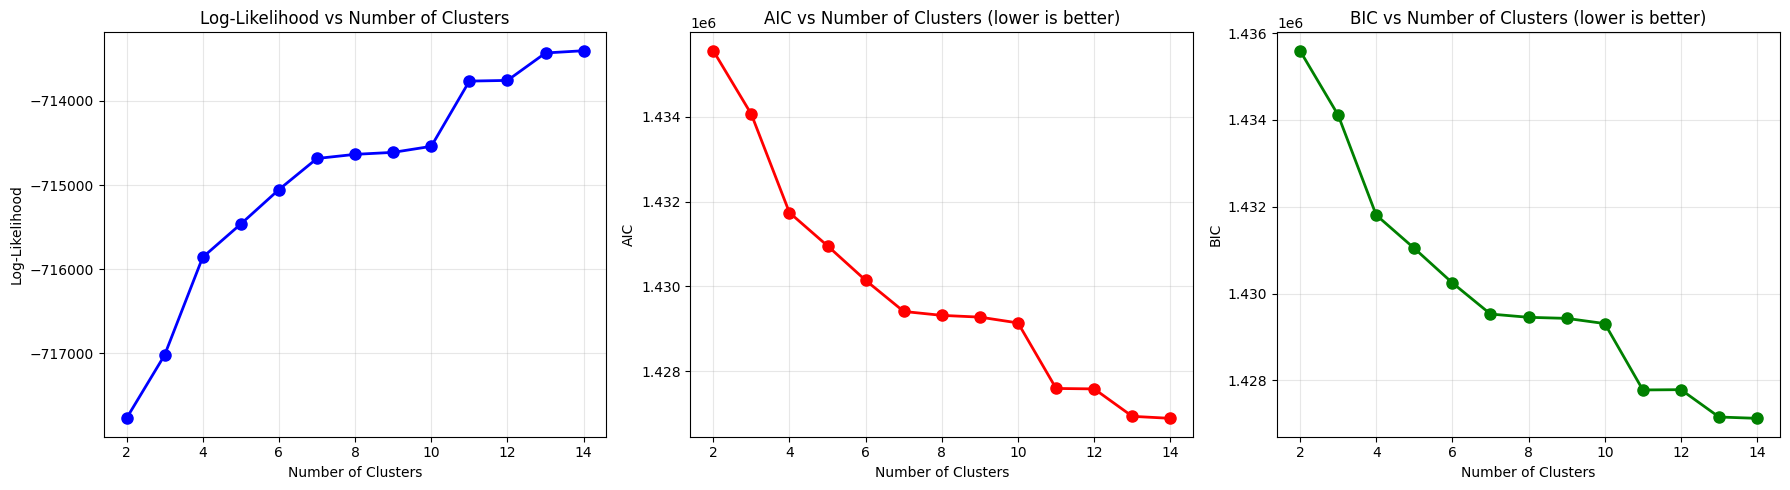

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13691607463783823, 0.05563612418162425, 10.321630605849528], 
    [0.10830975139189332, 0.057333515491559364, 10.862963835301928], 
    [0.08000219167272717, 1e-10, 29.021701723347906], 
    [0.1308321085184875, 0.05862651980538003, 9.740530923016202], 
    [0.07012394547111084, 0.007290222089530612, 18.089008251710723], 
    [0.09980383933102582, 0.04803355700085512, 8.909683510442468], 
    [0.1925942671045143, 0.027318610115234152, 6.8483329526083345], 
    [0.13854385394181648, 0.013432648249949575, 12.389938499574875],
    [0.12254650424537371, 0.04203161810618856, 12.724065545012929], 
    [0.12498708212032622, 0.0533917966054719, 15.694915502150147], 
    [0.12118597432385371, 0.06655404410415984, 9.749866385343088], 
    [0.07205427469746031, 0.07205427469746031, 6.505125537790015], 
    [0.07869849160434413, 0.04703758985644291, 7.673004431847952], 
    [0.13209232926330486, 0.08403562377266503, 9.147833829472706]
    ]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)

# Hill function with fixed m=10
def hill3k_hazard(a, mu_ub, mu_lb, K):
    m = 10
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def hill3k_survival_function(a, mu_ub, mu_lb, K):
    result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)
    return np.exp(-result)

def model_survival_curve_hill3k(ages, mu_ub, mu_lb, K):
    return np.array([hill3k_survival_function(a, mu_ub, mu_lb, K) for a in ages])

# Load actual survival data
survival_data = {}
ages_data = None  # Initialize to store consistent age bins


def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K = params  # Only 3 parameters now
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0:
        return -np.inf

    S_vals = model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def neg_log_likelihood_hill3k(params, ages, survivors, totals):
    return -log_likelihood(params, ages, survivors, totals)

def reestimate_cluster_params_mle(cluster_sectors):
    """
    Re-estimate parameters by maximizing likelihood on combined cluster data
    """
    print(f"Re-estimating parameters for sectors: {cluster_sectors}")
    
    # Combine data from all sectors in cluster
    combined_survivors = []
    combined_totals = []
    combined_ages = []
    
    for sector in cluster_sectors:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        
        # Ensure we only use data points where we have observations
        valid_mask = totals > 0
        survivors = survivors[valid_mask]
        totals = totals[valid_mask]
        
        # Use the same age bins for all sectors for consistency
        ages_sector = ages_data[:len(survivors)]  # Trim to match data length
        
        combined_survivors.extend(survivors)
        combined_totals.extend(totals)
        combined_ages.extend(ages_sector)
    
    combined_survivors = np.array(combined_survivors)
    combined_totals = np.array(combined_totals)
    combined_ages = np.array(combined_ages)
    
    # Remove any invalid data points
    valid_idx = (combined_totals > 0) & (combined_survivors >= 0) & (combined_survivors <= combined_totals)
    combined_survivors = combined_survivors[valid_idx]
    combined_totals = combined_totals[valid_idx]
    combined_ages = combined_ages[valid_idx]
    
    if len(combined_survivors) == 0:
        print(f"    Warning: No valid data for cluster {cluster_sectors}")
        return df_params.loc[cluster_sectors].mean().values
    
    # Use mean of individual sector parameters as initial guess
    initial_guess = df_params.loc[cluster_sectors].mean().values
    print(f"    Initial guess: mu_ub={initial_guess[0]:.4f}, mu_lb={initial_guess[1]:.4f}, K={initial_guess[2]:.4f}")
    
    # # Debug the initial parameters
    # try:
    #     debug_hill_function(initial_guess[0], initial_guess[1], initial_guess[2])
    # except:
    #     print("    Debug function failed, continuing with optimization...")
    
    # Define objective function with better error handling
    def neg_log_likelihood(params):
        try:
            ll = log_likelihood(params, combined_ages, combined_survivors, combined_totals)
            if not np.isfinite(ll):
                return 1e10
            return -ll
        except Exception as e:
            print(f"Likelihood computation failed: {e}")
            return 1e10
    
    # Set reasonable bounds for 3 parameters
    bounds = [(1e-6, 1.0),      # mu_ub
              (1e-10, 1.0),     # mu_lb  
              (0.1, 100.0)]     # K
    
    # Optimize with multiple attempts
    best_params = initial_guess
    best_ll = -1e10
    
    for attempt in range(3):  # Try multiple starting points
        try:
            if attempt == 0:
                start_params = initial_guess
            else:
                # Add some noise to initial guess for additional attempts (3 parameters)
                noise = np.random.normal(0, 0.05, size=3)  # Reduced noise
                start_params = np.abs(initial_guess + noise * initial_guess)
                # Ensure bounds are respected
                start_params[0] = np.clip(start_params[0], 1e-6, 1.0)
                start_params[1] = np.clip(start_params[1], 1e-10, min(1.0, start_params[0]))
                start_params[2] = np.clip(start_params[2], 0.1, 100.0)
            
            # print(f"    Attempt {attempt+1}: Starting with {start_params}")
            
            result = minimize(neg_log_likelihood, start_params, bounds=bounds, constraints =({'type': 'ineq', 'fun': lambda x: x[0] - x[1]}))
            
            if result.success:
                ll = log_likelihood(result.x, combined_ages, combined_survivors, combined_totals)
                # print(f"    Attempt {attempt+1}: Success, LL={ll:.2f}")
                if ll > best_ll:
                    best_ll = ll
                    best_params = result.x
            else:
                print(f"Attempt {attempt+1}: Failed - {result.message}")
                    
        except Exception as e:
            print(f"Optimization attempt {attempt+1} failed: {e}")
            continue
    
    print(f"Final parameters: mu_ub={best_params[0]:.4f}, mu_lb={best_params[1]:.4f}, K={best_params[2]:.4f}")
    return best_params

def compute_sector_likelihood(sector, model_params):
    """    
    Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    
    # Use consistent age bins and filter out invalid data
    valid_mask = totals > 0
    survivors = survivors[valid_mask]
    totals = totals[valid_mask]
    ages_sector = ages_data[:len(survivors)]  # Use consistent age bins
    
    if len(survivors) == 0:
        return -np.inf
        
    return log_likelihood(model_params, ages_sector, survivors, totals)

# Generalized iterative clustering algorithm (rest of the code remains the same)
def iterative_likelihood_clustering(survival_data, df_params, n_clusters=2, max_iterations=20, tolerance=1e-6):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in range(n_clusters):
        mask = initial_clusters == cluster_id
        if np.sum(mask) > 0:
            cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
        else:
            cluster_params[cluster_id] = df_params.values[np.random.randint(0, n_sectors)]
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters (m=5 fixed):")
    for cluster_id, params in cluster_params.items():
        n_in_cluster = np.sum(initial_clusters == cluster_id)
        print(f"  Cluster {cluster_id} ({n_in_cluster} sectors): mu_ub={params[0]:.4f}, mu_lb={params[1]:.4f}, K={params[2]:.4f}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                cluster_lls[cluster_id] = compute_sector_likelihood(sector, cluster_params[cluster_id])
            
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters using MLE
        new_cluster_params = {}
        for cluster_id in range(n_clusters):
            mask = new_clusters == cluster_id
            cluster_sectors = [sector_names[i] for i in range(n_sectors) if mask[i]]
            
            if len(cluster_sectors) > 0:
                try:
                    new_cluster_params[cluster_id] = reestimate_cluster_params_mle(cluster_sectors)
                except Exception as e:
                    print(f"  Warning: MLE failed for cluster {cluster_id}: {e}, using mean")
                    new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters (m=5 fixed):")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): mu_ub={params[0]:.4f}, mu_lb={params[1]:.4f}, K={params[2]:.4f}")
        
        # Check convergence - simplified for 3 parameters
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        # Standard parameter change calculation
        param_change = 0
        for cluster_id in range(n_clusters):
            param_change += np.sum((new_cluster_params[cluster_id] - cluster_params[cluster_id])**2)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Parameter change: {param_change:.6f}")
        
        if not clusters_changed and param_change < tolerance:
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Function to compute AIC and BIC for model comparison
def compute_model_selection_criteria(final_clusters, final_params, n_clusters):
    """
    Compute AIC and BIC for the clustering solution
    """
    total_ll = 0
    total_obs = 0
    
    for i, sector in enumerate(sector_list):
        assigned_cluster = final_clusters[i]
        sector_ll = compute_sector_likelihood(sector, final_params[assigned_cluster])
        total_ll += sector_ll
        
        # Count actual observations for this sector
        totals, _ = obtain_total_alive_count(df_analysis, 'Sector', sector)
        total_obs += np.sum(totals > 0)
    
    # Number of parameters: n_clusters * 3 parameters per cluster (m fixed at 10)
    n_params = n_clusters * 3
    
    # AIC and BIC
    AIC = -2 * total_ll + 2 * n_params
    BIC = -2 * total_ll + np.log(total_obs) * n_params
    
    return total_ll, AIC, BIC, n_params

for i, sector in enumerate(sector_list):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    survival_data[sector] = survival_fractions
    
    # Use the first sector's ages as reference for all sectors
    if i == 0:
        ages_data = ages

print("\n" + "="*60)
print("STARTING CLUSTERING ANALYSIS")
print("="*60)
results = {}
model_comparison = {}

for k in range(2, 15):
    print(f"\n{'='*60}")
    print(f"RUNNING {k}-CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    final_clusters, final_params, history = iterative_likelihood_clustering(
        survival_data, df_params, n_clusters=k
    )
    
    # Store results
    results[k] = {
        'clusters': final_clusters,
        'params': final_params,
        'history': history
    }
    
    # Compute model selection criteria
    total_ll, AIC, BIC, n_params = compute_model_selection_criteria(final_clusters, final_params, k)
    model_comparison[k] = {
        'log_likelihood': total_ll,
        'AIC': AIC,
        'BIC': BIC,
        'n_params': n_params
    }
    
    print(f"\n{k}-CLUSTER FINAL RESULTS:")
    print(f"Total Log-Likelihood: {total_ll:.2f}")
    print(f"AIC: {AIC:.2f}")
    print(f"BIC: {BIC:.2f}")
    
    print(f"\nFinal cluster assignments:")
    for i, sector in enumerate(sector_list):
        print(f"  {sector}: Cluster {final_clusters[i]}")
    
    print(f"\nFinal cluster parameters (m=10 fixed):")
    for cluster_id, params in final_params.items():
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
        print(f"  mu_ub: {params[0]:.6f}")
        print(f"  mu_lb: {params[1]:.6f}")
        print(f"  K: {params[2]:.6f}")
        print(f"  m: 10.0 (fixed)")

# Model comparison summary
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame(model_comparison).T
comparison_df.index.name = 'n_clusters'
print(comparison_df)

# Find best model by AIC and BIC
best_aic = comparison_df['AIC'].idxmin()
best_bic = comparison_df['BIC'].idxmin()
best_ll = comparison_df['log_likelihood'].idxmax()

print(f"\nBest model by AIC: {best_aic} clusters")
print(f"Best model by BIC: {best_bic} clusters")
print(f"Best model by Log-Likelihood: {best_ll} clusters")

# Plot model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Log-likelihood
axes[0].plot(comparison_df.index, comparison_df['log_likelihood'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Log-Likelihood')
axes[0].set_title('Log-Likelihood vs Number of Clusters')
axes[0].grid(True, alpha=0.3)

# AIC
axes[1].plot(comparison_df.index, comparison_df['AIC'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('AIC')
axes[1].set_title('AIC vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

# BIC
axes[2].plot(comparison_df.index, comparison_df['BIC'], 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('BIC')
axes[2].set_title('BIC vs Number of Clusters')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans

# --- Hill hazard and survival functions ---
def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return -np.inf
    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)
    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

# --- Joint negative log-likelihood for all clusters with shared m ---
def joint_neg_log_likelihood(params, cluster_sector_map, sector_data, ages_data):
    n_clusters = len(cluster_sector_map)
    m = params[-1]
    total_ll = 0
    for k in range(n_clusters):
        mu_ub, mu_lb, K = params[3*k:3*k+3]
        sectors = cluster_sector_map[k]
        combined_survivors = []
        combined_totals = []
        combined_ages = []
        for sector in sectors:
            totals, survivors = sector_data[sector]
            valid_mask = totals > 0
            survivors = survivors[valid_mask]
            totals = totals[valid_mask]
            ages_sector = ages_data[:len(survivors)]
            combined_survivors.extend(survivors)
            combined_totals.extend(totals)
            combined_ages.extend(ages_sector)
        combined_survivors = np.array(combined_survivors)
        combined_totals = np.array(combined_totals)
        combined_ages = np.array(combined_ages)
        ll = log_likelihood([mu_ub, mu_lb, K, m], combined_ages, combined_survivors, combined_totals)
        total_ll += ll
    return -total_ll  # minimize negative log-likelihood

# --- Main clustering function ---
def cluster_sectors_with_shared_m(sector_list, df_params, df_analysis, ages_data, n_clusters=3, max_iterations=20, tolerance=1e-4):
    # Prepare sector data
    sector_data = {}
    for sector in sector_list:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        sector_data[sector] = (totals, survivors)

    # Step 1: Initial cluster assignment using k-means on mu_ub, mu_lb, K
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_params = df_params[['mu_ub', 'mu_lb', 'K']].values
    initial_clusters = kmeans.fit_predict(initial_params)

    # Map clusters to sector names
    cluster_sector_map = {k: [] for k in range(n_clusters)}
    for i, cluster_id in enumerate(initial_clusters):
        cluster_sector_map[cluster_id].append(sector_list[i])

    # Step 2: Build initial guess for optimization
    initial_guess = []
    for k in range(n_clusters):
        mean_params = df_params.loc[cluster_sector_map[k]][['mu_ub', 'mu_lb', 'K']].mean().values
        initial_guess.extend(mean_params)
    initial_m = df_params['m'].mean() if 'm' in df_params.columns else 10.0
    initial_guess.append(initial_m)

    # Step 3: Set bounds and constraints
    bounds = [(1e-6, 0.3), (1e-6, 0.15), (0.1, 50.0)] * n_clusters + [(0.1, 100.0)]
    constraints = [{'type': 'ineq', 'fun': lambda x, k=k: x[3*k] - x[3*k+1]} for k in range(n_clusters)]

    # Step 4: Optimize
    result = minimize(
        joint_neg_log_likelihood,
        initial_guess,
        args=(cluster_sector_map, sector_data, ages_data),
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000}
    )

    # Step 5: Extract results
    params = result.x
    clusters_params = {}
    for k in range(n_clusters):
        clusters_params[k] = {
            'mu_ub': params[3*k],
            'mu_lb': params[3*k+1],
            'K': params[3*k+2],
            'm': params[-1]
        }
    shared_m = params[-1]

    # Print results
    print(f"\nOptimized shared m: {shared_m:.4f}")
    for k in range(n_clusters):
        print(f"Cluster {k}: sectors={cluster_sector_map[k]}")
        print(f"  mu_ub={clusters_params[k]['mu_ub']:.4f}, mu_lb={clusters_params[k]['mu_lb']:.4f}, K={clusters_params[k]['K']:.4f}, m={shared_m:.4f}")

    return cluster_sector_map, clusters_params, shared_m, result

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212], 
    [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619], 
    [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219], 
    [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392], 
    [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189], 
    [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0], 
    [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0], 
    [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204], 
    [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744], 
    [0.12639658719104133, 1.0000000249470075e-10, 20.851108767628933, 3.8694205399833757], 
    [0.1212132957507885, 0.06868421106599219, 9.445203344625348, 100.0], 
    [0.07305173006148806, 0.07305173006148806, 4.686889369376459, 49.86003240187913], 
    [0.07830160011697058, 0.047197607271208426, 7.792050676547918, 100.0], 
    [0.13228889671445893, 0.0854858990969846, 8.857658026221204, 100.0]
    ]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

cluster_sector_map, clusters_params, shared_m, result = cluster_sectors_with_shared_m(
    sector_list, df_params, df_analysis, ages_data, n_clusters=3
)


Optimized shared m: 100.0000
Cluster 0: sectors=['G', 'M', 'J', 'C', 'S', 'P', 'R']
  mu_ub=0.1264, mu_lb=0.0584, K=9.6215, m=100.0000
Cluster 1: sectors=['K', 'N', 'I']
  mu_ub=0.0946, mu_lb=0.0000, K=19.6867, m=100.0000
Cluster 2: sectors=['F', 'H', 'L', 'Q']
  mu_ub=0.1283, mu_lb=0.0508, K=6.7772, m=100.0000


In [ ]:
def reestimate_all_clusters_jointly(cluster_assignments, sector_list, df_params, df_analysis, ages_data, n_clusters):
    # Prepare cluster_sector_map
    cluster_sector_map = {k: [] for k in range(n_clusters)}
    for i, cluster_id in enumerate(cluster_assignments):
        cluster_sector_map[cluster_id].append(sector_list[i])
    # Prepare sector_data
    sector_data = {}
    for sector in sector_list:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        sector_data[sector] = (totals, survivors)
    # Initial guess
    initial_guess = []
    for k in range(n_clusters):
        mean_params = df_params.loc[cluster_sector_map[k]][['mu_ub', 'mu_lb', 'K']].mean().values
        initial_guess.extend(mean_params)
    initial_m = df_params['m'].mean() if 'm' in df_params.columns else 10.0
    initial_guess.append(initial_m)
    # Bounds and constraints
    bounds = [(1e-6, 0.3), (1e-6, 0.15), (0.1, 50.0)] * n_clusters + [(0.1, 100.0)]
    constraints = [{'type': 'ineq', 'fun': lambda x, k=k: x[3*k] - x[3*k+1]} for k in range(n_clusters)]
    # Optimize
    result = minimize(
        joint_neg_log_likelihood,
        initial_guess,
        args=(cluster_sector_map, sector_data, ages_data),
        bounds=bounds,
        constraints=constraints
    )
    params = result.x
    clusters_params = {}
    for k in range(n_clusters):
        clusters_params[k] = {
            'mu_ub': params[3*k],
            'mu_lb': params[3*k+1],
            'K': params[3*k+2],
            'm': params[-1]
        }
    shared_m = params[-1]
    return clusters_params, shared_m, result

# Constant m clustering function
def iterative_likelihood_clustering_shared_m(
    survival_data, df_params, df_analysis, ages_data,
    n_clusters=2, max_iterations=20, tolerance=1, m_tolerance=0.5):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    Jointly re-estimates all cluster parameters and shared m at each iteration.
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())

    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params[['mu_ub', 'mu_lb', 'K']].values)

    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"{sector}: Cluster {initial_clusters[i]}")

    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False

    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'shared_m': [],
        'total_likelihood': []
    }

    # Initial parameter estimation using joint optimizer
    clusters_params, shared_m, _ = reestimate_all_clusters_jointly(
        current_clusters, sector_names, df_params, df_analysis, ages_data, n_clusters
    )

    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")

        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}

        for i, sector in enumerate(sector_names):
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                params = clusters_params[cluster_id]
                ll = compute_sector_likelihood(
                    sector,
                    [params['mu_ub'], params['mu_lb'], params['K'], shared_m]
                )
                cluster_lls[cluster_id] = ll
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}

        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")

        # Step 3: Jointly re-estimate all cluster parameters and shared m
        try:
            new_clusters_params, new_shared_m, _ = reestimate_all_clusters_jointly(
                new_clusters, sector_names, df_params, df_analysis, ages_data, n_clusters
            )
        except Exception as e:
            print(f"  Warning: Joint optimization failed: {e}")
            # Fallback: Use previous parameters
            new_clusters_params = clusters_params.copy()
            new_shared_m = shared_m

        print("Updated cluster parameters:")
        for cluster_id in range(n_clusters):
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            params = new_clusters_params.get(cluster_id, clusters_params.get(cluster_id))
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): {params}")

        # Check convergence with weighted parameter changes
        clusters_changed = not np.array_equal(current_clusters, new_clusters)

        param_change = 0
        param_weights = [1.0, 1.0, 1.0, 0.02]  # Less weight on m parameter (index 3)
        for cluster_id in range(n_clusters):
            old_params = clusters_params.get(cluster_id)
            new_params = new_clusters_params.get(cluster_id, old_params)
            if old_params is None or new_params is None:
                continue
            weighted_diff = np.sum([
                (new_params['mu_ub'] - old_params['mu_ub'])**2 * param_weights[0],
                (new_params['mu_lb'] - old_params['mu_lb'])**2 * param_weights[1],
                (new_params['K'] - old_params['K'])**2 * param_weights[2],
                (new_shared_m - shared_m)**2 * param_weights[3]
            ])
            param_change += weighted_diff / n_clusters

        # Also check relative changes for m parameter specifically
        if shared_m > 0:
            max_m_relative_change = abs(new_shared_m - shared_m) / shared_m
        else:
            max_m_relative_change = 0

        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Weighted parameter change: {param_change:.6f}")
        print(f"  Max relative m change: {max_m_relative_change:.3f}")

        if (not clusters_changed and
            param_change < tolerance and
            max_m_relative_change < m_tolerance):
            converged = True
            print("  → Converged!")

        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            params = new_clusters_params.get(assigned_cluster, clusters_params.get(assigned_cluster))
            total_ll += compute_sector_likelihood(
                sector,
                [params['mu_ub'], params['mu_lb'], params['K'], new_shared_m]
            )

        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_clusters_params.copy())
        history['shared_m'].append(new_shared_m)
        history['total_likelihood'].append(total_ll)

        # Update for next iteration
        current_clusters = new_clusters.copy()
        clusters_params = new_clusters_params.copy()
        shared_m = new_shared_m

    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")

    return current_clusters, clusters_params, shared_m, history

In [24]:
current_clusters, clusters_params, shared_m, history = iterative_likelihood_clustering_shared_m(
    survival_data, df_params, df_analysis, ages_data, n_clusters=3)


Initializing 3-cluster analysis with k-means clustering...
Initial cluster assignments:
G: Cluster 0
M: Cluster 0
F: Cluster 2
J: Cluster 0
K: Cluster 1
C: Cluster 0
H: Cluster 2
S: Cluster 0
N: Cluster 1
I: Cluster 1
P: Cluster 0
L: Cluster 2
Q: Cluster 2
R: Cluster 0

--- Iteration 1 ---
Likelihood-based assignments:
  G: LL_0=-198968.34, LL_1=-205442.72, LL_2=-203752.95 → Cluster 0
  M: LL_0=-107562.76, LL_1=-107334.16, LL_2=-107635.15 → Cluster 1
  F: LL_0=-49698.78, LL_1=-48358.85, LL_2=-48814.92 → Cluster 1
  J: LL_0=-57006.79, LL_1=-58464.71, LL_2=-57692.66 → Cluster 0
  K: LL_0=-62270.36, LL_1=-58489.55, LL_2=-60139.12 → Cluster 1
  C: LL_0=-40779.88, LL_1=-39991.10, LL_2=-39830.11 → Cluster 2
  H: LL_0=-44921.53, LL_1=-48089.43, LL_2=-44960.62 → Cluster 0
  S: LL_0=-35971.98, LL_1=-37000.03, LL_2=-36656.44 → Cluster 0
  N: LL_0=-37054.93, LL_1=-37629.31, LL_2=-37619.61 → Cluster 0
  I: LL_0=-34494.32, LL_1=-35451.03, LL_2=-35381.26 → Cluster 0
  P: LL_0=-25171.38, LL_1=-25552


Running 3-cluster analysis with shared m...

Initializing 3-cluster analysis with k-means clustering...
Initial cluster assignments:
G: Cluster 0
M: Cluster 0
F: Cluster 2
J: Cluster 0
K: Cluster 1
C: Cluster 0
H: Cluster 2
S: Cluster 0
N: Cluster 1
I: Cluster 1
P: Cluster 0
L: Cluster 2
Q: Cluster 2
R: Cluster 0

--- Iteration 1 ---
Likelihood-based assignments:
  G: LL_0=-198968.34, LL_1=-205442.72, LL_2=-203752.95 → Cluster 0
  M: LL_0=-107562.76, LL_1=-107334.16, LL_2=-107635.15 → Cluster 1
  F: LL_0=-49698.78, LL_1=-48358.85, LL_2=-48814.92 → Cluster 1
  J: LL_0=-57006.79, LL_1=-58464.71, LL_2=-57692.66 → Cluster 0
  K: LL_0=-62270.36, LL_1=-58489.55, LL_2=-60139.12 → Cluster 1
  C: LL_0=-40779.88, LL_1=-39991.10, LL_2=-39830.11 → Cluster 2
  H: LL_0=-44921.53, LL_1=-48089.43, LL_2=-44960.62 → Cluster 0
  S: LL_0=-35971.98, LL_1=-37000.03, LL_2=-36656.44 → Cluster 0
  N: LL_0=-37054.93, LL_1=-37629.31, LL_2=-37619.61 → Cluster 0
  I: LL_0=-34494.32, LL_1=-35451.03, LL_2=-35381.26

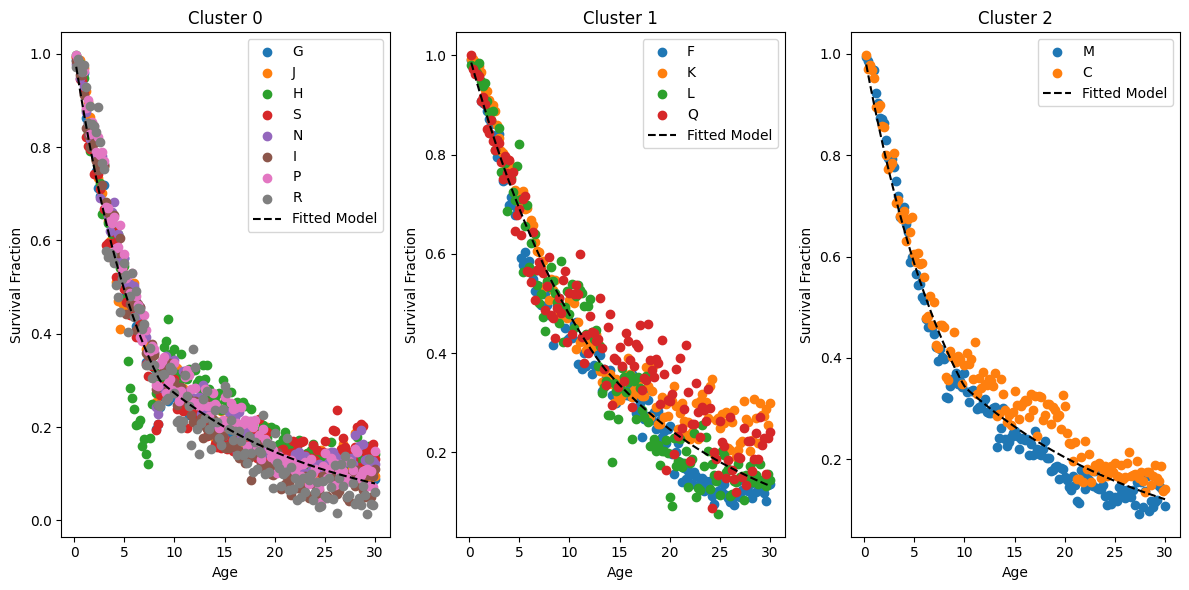


Running 14-cluster analysis with shared m...

Initializing 14-cluster analysis with k-means clustering...
Initial cluster assignments:
G: Cluster 3
M: Cluster 9
F: Cluster 10
J: Cluster 11
K: Cluster 1
C: Cluster 0
H: Cluster 2
S: Cluster 4
N: Cluster 7
I: Cluster 5
P: Cluster 12
L: Cluster 6
Q: Cluster 8
R: Cluster 13

--- Iteration 1 ---
Likelihood-based assignments:
  G: LL_0=-209385.65, LL_1=-229853.39, LL_2=-203192.34, LL_3=-198294.84, LL_4=-200109.90, LL_5=-200165.73, LL_6=-219770.84, LL_7=-199261.76, LL_8=-227752.10, LL_9=-201877.14, LL_10=-212729.15, LL_11=-198551.85, LL_12=-199228.69, LL_13=-198902.79 → Cluster 3
  M: LL_0=-107950.76, LL_1=-113575.59, LL_2=-112973.22, LL_3=-108841.91, LL_4=-109910.38, LL_5=-110011.23, LL_6=-111159.02, LL_7=-108524.08, LL_8=-113072.34, LL_9=-106893.27, LL_10=-109041.34, LL_11=-107962.49, LL_12=-107364.54, LL_13=-108951.39 → Cluster 9
  F: LL_0=-48227.63, LL_1=-49597.54, LL_2=-52534.56, LL_3=-50872.78, LL_4=-51755.99, LL_5=-52080.69, LL_6=-4793

C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: T

Likelihood-based assignments:
  G: LL_0=-209385.65, LL_1=-229853.39, LL_2=-203192.34, LL_3=-198294.84, LL_4=-200109.90, LL_5=nan, LL_6=-219770.84, LL_7=nan, LL_8=-227752.10, LL_9=-201877.14, LL_10=-212729.15, LL_11=-198873.93, LL_12=-199228.69, LL_13=-198884.47 → Cluster 3
  M: LL_0=-107950.76, LL_1=-113575.59, LL_2=-112973.22, LL_3=-108841.91, LL_4=-109910.38, LL_5=nan, LL_6=-111159.02, LL_7=nan, LL_8=-113072.34, LL_9=-106893.27, LL_10=-109041.34, LL_11=-108205.40, LL_12=-107364.54, LL_13=-109335.39 → Cluster 9
  F: LL_0=-48227.63, LL_1=-49597.54, LL_2=-52534.56, LL_3=-50872.78, LL_4=-51755.99, LL_5=nan, LL_6=-47939.29, LL_7=nan, LL_8=-49084.29, LL_9=-48587.96, LL_10=-47781.69, LL_11=-50407.47, LL_12=-49517.92, LL_13=-51464.96 → Cluster 10
  J: LL_0=-58948.23, LL_1=-63870.83, LL_2=-58684.68, LL_3=-57045.31, LL_4=-57369.91, LL_5=nan, LL_6=-62165.05, LL_7=nan, LL_8=-63138.13, LL_9=-57563.10, LL_10=-60315.25, LL_11=-57049.78, LL_12=-57063.44, LL_13=-57206.83 → Cluster 3
  K: LL_0=-57805.

C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: T

Likelihood-based assignments:
  G: LL_0=-209385.65, LL_1=-229853.39, LL_2=-203192.34, LL_3=-198386.39, LL_4=-200109.90, LL_5=nan, LL_6=-219770.84, LL_7=nan, LL_8=-227752.10, LL_9=-201877.14, LL_10=-212729.15, LL_11=nan, LL_12=-199204.16, LL_13=-200165.73 → Cluster 3
  M: LL_0=-107950.76, LL_1=-113575.59, LL_2=-112973.22, LL_3=-108496.66, LL_4=-109910.38, LL_5=nan, LL_6=-111159.02, LL_7=nan, LL_8=-113072.34, LL_9=-106893.27, LL_10=-109041.34, LL_11=nan, LL_12=-107735.70, LL_13=-110011.23 → Cluster 9
  F: LL_0=-48227.63, LL_1=-49597.54, LL_2=-52534.56, LL_3=-50638.57, LL_4=-51755.99, LL_5=nan, LL_6=-47939.29, LL_7=nan, LL_8=-49084.29, LL_9=-48587.96, LL_10=-47781.69, LL_11=nan, LL_12=-49973.52, LL_13=-52080.69 → Cluster 10
  J: LL_0=-58948.23, LL_1=-63870.83, LL_2=-58684.68, LL_3=-57012.46, LL_4=-57369.91, LL_5=nan, LL_6=-62165.05, LL_7=nan, LL_8=-63138.13, LL_9=-57563.10, LL_10=-60315.25, LL_11=nan, LL_12=-57072.44, LL_13=-57490.47 → Cluster 3
  K: LL_0=-57805.27, LL_1=-56219.06, LL_2=-

C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: T

Likelihood-based assignments:
  G: LL_0=-209385.65, LL_1=-229853.39, LL_2=-203192.34, LL_3=-198386.39, LL_4=-200109.90, LL_5=nan, LL_6=-219770.84, LL_7=nan, LL_8=-227752.10, LL_9=-201877.14, LL_10=-212729.15, LL_11=nan, LL_12=-199204.16, LL_13=-200165.73 → Cluster 3
  M: LL_0=-107950.76, LL_1=-113575.59, LL_2=-112973.22, LL_3=-108496.66, LL_4=-109910.38, LL_5=nan, LL_6=-111159.02, LL_7=nan, LL_8=-113072.34, LL_9=-106893.27, LL_10=-109041.34, LL_11=nan, LL_12=-107735.70, LL_13=-110011.23 → Cluster 9
  F: LL_0=-48227.63, LL_1=-49597.54, LL_2=-52534.56, LL_3=-50638.57, LL_4=-51755.99, LL_5=nan, LL_6=-47939.29, LL_7=nan, LL_8=-49084.29, LL_9=-48587.96, LL_10=-47781.69, LL_11=nan, LL_12=-49973.52, LL_13=-52080.69 → Cluster 10
  J: LL_0=-58948.23, LL_1=-63870.83, LL_2=-58684.68, LL_3=-57012.46, LL_4=-57369.91, LL_5=nan, LL_6=-62165.05, LL_7=nan, LL_8=-63138.13, LL_9=-57563.10, LL_10=-60315.25, LL_11=nan, LL_12=-57072.44, LL_13=-57490.47 → Cluster 3
  K: LL_0=-57805.27, LL_1=-56219.06, LL_2=-

C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: T

Likelihood-based assignments:
  G: LL_0=-209385.65, LL_1=-229853.39, LL_2=-203192.34, LL_3=-198386.39, LL_4=-200109.90, LL_5=nan, LL_6=-219770.84, LL_7=nan, LL_8=-227752.10, LL_9=-201877.14, LL_10=-212729.15, LL_11=nan, LL_12=-199204.16, LL_13=-200165.73 → Cluster 3
  M: LL_0=-107950.76, LL_1=-113575.59, LL_2=-112973.22, LL_3=-108496.66, LL_4=-109910.38, LL_5=nan, LL_6=-111159.02, LL_7=nan, LL_8=-113072.34, LL_9=-106893.27, LL_10=-109041.34, LL_11=nan, LL_12=-107735.70, LL_13=-110011.23 → Cluster 9
  F: LL_0=-48227.63, LL_1=-49597.54, LL_2=-52534.56, LL_3=-50638.57, LL_4=-51755.99, LL_5=nan, LL_6=-47939.29, LL_7=nan, LL_8=-49084.29, LL_9=-48587.96, LL_10=-47781.69, LL_11=nan, LL_12=-49973.52, LL_13=-52080.69 → Cluster 10
  J: LL_0=-58948.23, LL_1=-63870.83, LL_2=-58684.68, LL_3=-57012.46, LL_4=-57369.91, LL_5=nan, LL_6=-62165.05, LL_7=nan, LL_8=-63138.13, LL_9=-57563.10, LL_10=-60315.25, LL_11=nan, LL_12=-57072.44, LL_13=-57490.47 → Cluster 3
  K: LL_0=-57805.27, LL_1=-56219.06, LL_2=-

C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: T

Likelihood-based assignments:
  G: LL_0=-209385.65, LL_1=-229853.39, LL_2=-203192.34, LL_3=-198386.39, LL_4=-200109.90, LL_5=nan, LL_6=-219770.84, LL_7=nan, LL_8=-227752.10, LL_9=-201877.14, LL_10=-212729.15, LL_11=nan, LL_12=-199204.16, LL_13=-200165.73 → Cluster 3
  M: LL_0=-107950.76, LL_1=-113575.59, LL_2=-112973.22, LL_3=-108496.66, LL_4=-109910.38, LL_5=nan, LL_6=-111159.02, LL_7=nan, LL_8=-113072.34, LL_9=-106893.27, LL_10=-109041.34, LL_11=nan, LL_12=-107735.70, LL_13=-110011.23 → Cluster 9
  F: LL_0=-48227.63, LL_1=-49597.54, LL_2=-52534.56, LL_3=-50638.57, LL_4=-51755.99, LL_5=nan, LL_6=-47939.29, LL_7=nan, LL_8=-49084.29, LL_9=-48587.96, LL_10=-47781.69, LL_11=nan, LL_12=-49973.52, LL_13=-52080.69 → Cluster 10
  J: LL_0=-58948.23, LL_1=-63870.83, LL_2=-58684.68, LL_3=-57012.46, LL_4=-57369.91, LL_5=nan, LL_6=-62165.05, LL_7=nan, LL_8=-63138.13, LL_9=-57563.10, LL_10=-60315.25, LL_11=nan, LL_12=-57072.44, LL_13=-57490.47 → Cluster 3
  K: LL_0=-57805.27, LL_1=-56219.06, LL_2=-

C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: T

Likelihood-based assignments:
  G: LL_0=-209385.65, LL_1=-229853.39, LL_2=-203192.34, LL_3=-198386.39, LL_4=-200109.90, LL_5=nan, LL_6=-219770.84, LL_7=nan, LL_8=-227752.10, LL_9=-201877.14, LL_10=-212729.15, LL_11=nan, LL_12=-199204.16, LL_13=-200165.73 → Cluster 3
  M: LL_0=-107950.76, LL_1=-113575.59, LL_2=-112973.22, LL_3=-108496.66, LL_4=-109910.38, LL_5=nan, LL_6=-111159.02, LL_7=nan, LL_8=-113072.34, LL_9=-106893.27, LL_10=-109041.34, LL_11=nan, LL_12=-107735.70, LL_13=-110011.23 → Cluster 9
  F: LL_0=-48227.63, LL_1=-49597.54, LL_2=-52534.56, LL_3=-50638.57, LL_4=-51755.99, LL_5=nan, LL_6=-47939.29, LL_7=nan, LL_8=-49084.29, LL_9=-48587.96, LL_10=-47781.69, LL_11=nan, LL_12=-49973.52, LL_13=-52080.69 → Cluster 10
  J: LL_0=-58948.23, LL_1=-63870.83, LL_2=-58684.68, LL_3=-57012.46, LL_4=-57369.91, LL_5=nan, LL_6=-62165.05, LL_7=nan, LL_8=-63138.13, LL_9=-57563.10, LL_10=-60315.25, LL_11=nan, LL_12=-57072.44, LL_13=-57490.47 → Cluster 3
  K: LL_0=-57805.27, LL_1=-56219.06, LL_2=-

C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: T

Likelihood-based assignments:
  G: LL_0=-209385.65, LL_1=-229853.39, LL_2=-203192.34, LL_3=-198386.39, LL_4=-200109.90, LL_5=nan, LL_6=-219770.84, LL_7=nan, LL_8=-227752.10, LL_9=-201877.14, LL_10=-212729.15, LL_11=nan, LL_12=-199204.16, LL_13=-200165.73 → Cluster 3
  M: LL_0=-107950.76, LL_1=-113575.59, LL_2=-112973.22, LL_3=-108496.66, LL_4=-109910.38, LL_5=nan, LL_6=-111159.02, LL_7=nan, LL_8=-113072.34, LL_9=-106893.27, LL_10=-109041.34, LL_11=nan, LL_12=-107735.70, LL_13=-110011.23 → Cluster 9
  F: LL_0=-48227.63, LL_1=-49597.54, LL_2=-52534.56, LL_3=-50638.57, LL_4=-51755.99, LL_5=nan, LL_6=-47939.29, LL_7=nan, LL_8=-49084.29, LL_9=-48587.96, LL_10=-47781.69, LL_11=nan, LL_12=-49973.52, LL_13=-52080.69 → Cluster 10
  J: LL_0=-58948.23, LL_1=-63870.83, LL_2=-58684.68, LL_3=-57012.46, LL_4=-57369.91, LL_5=nan, LL_6=-62165.05, LL_7=nan, LL_8=-63138.13, LL_9=-57563.10, LL_10=-60315.25, LL_11=nan, LL_12=-57072.44, LL_13=-57490.47 → Cluster 3
  K: LL_0=-57805.27, LL_1=-56219.06, LL_2=-

C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: T

Likelihood-based assignments:
  G: LL_0=-209385.65, LL_1=-229853.39, LL_2=-203192.34, LL_3=-198386.39, LL_4=-200109.90, LL_5=nan, LL_6=-219770.84, LL_7=nan, LL_8=-227752.10, LL_9=-201877.14, LL_10=-212729.15, LL_11=nan, LL_12=-199204.16, LL_13=-200165.73 → Cluster 3
  M: LL_0=-107950.76, LL_1=-113575.59, LL_2=-112973.22, LL_3=-108496.66, LL_4=-109910.38, LL_5=nan, LL_6=-111159.02, LL_7=nan, LL_8=-113072.34, LL_9=-106893.27, LL_10=-109041.34, LL_11=nan, LL_12=-107735.70, LL_13=-110011.23 → Cluster 9
  F: LL_0=-48227.63, LL_1=-49597.54, LL_2=-52534.56, LL_3=-50638.57, LL_4=-51755.99, LL_5=nan, LL_6=-47939.29, LL_7=nan, LL_8=-49084.29, LL_9=-48587.96, LL_10=-47781.69, LL_11=nan, LL_12=-49973.52, LL_13=-52080.69 → Cluster 10
  J: LL_0=-58948.23, LL_1=-63870.83, LL_2=-58684.68, LL_3=-57012.46, LL_4=-57369.91, LL_5=nan, LL_6=-62165.05, LL_7=nan, LL_8=-63138.13, LL_9=-57563.10, LL_10=-60315.25, LL_11=nan, LL_12=-57072.44, LL_13=-57490.47 → Cluster 3
  K: LL_0=-57805.27, LL_1=-56219.06, LL_2=-

C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
C:\Users\chong\AppData\Local\Temp\ipykernel_7144\3682965178.py:12: IntegrationWarning: T

Likelihood-based assignments:
  G: LL_0=-209385.65, LL_1=-229853.39, LL_2=-203192.34, LL_3=-198386.39, LL_4=-200109.90, LL_5=nan, LL_6=-219770.84, LL_7=nan, LL_8=-227752.10, LL_9=-201877.14, LL_10=-212729.15, LL_11=nan, LL_12=-199204.16, LL_13=-200165.73 → Cluster 3
  M: LL_0=-107950.76, LL_1=-113575.59, LL_2=-112973.22, LL_3=-108496.66, LL_4=-109910.38, LL_5=nan, LL_6=-111159.02, LL_7=nan, LL_8=-113072.34, LL_9=-106893.27, LL_10=-109041.34, LL_11=nan, LL_12=-107735.70, LL_13=-110011.23 → Cluster 9
  F: LL_0=-48227.63, LL_1=-49597.54, LL_2=-52534.56, LL_3=-50638.57, LL_4=-51755.99, LL_5=nan, LL_6=-47939.29, LL_7=nan, LL_8=-49084.29, LL_9=-48587.96, LL_10=-47781.69, LL_11=nan, LL_12=-49973.52, LL_13=-52080.69 → Cluster 10
  J: LL_0=-58948.23, LL_1=-63870.83, LL_2=-58684.68, LL_3=-57012.46, LL_4=-57369.91, LL_5=nan, LL_6=-62165.05, LL_7=nan, LL_8=-63138.13, LL_9=-57563.10, LL_10=-60315.25, LL_11=nan, LL_12=-57072.44, LL_13=-57490.47 → Cluster 3
  K: LL_0=-57805.27, LL_1=-56219.06, LL_2=-

KeyboardInterrupt: 

In [38]:
ll_list = []
bic_list = []

for n in [3, 14]:
    print(f"\nRunning {n}-cluster analysis with shared m...")
    current_clusters, clusters_params, shared_m, history = iterative_likelihood_clustering_shared_m(
    survival_data, df_params, df_analysis, ages_data, n_clusters=n)
    print(f"Log-Likelihood: {history['total_likelihood'][-1]}")
    print(f"AIC: {2 * (-history['total_likelihood'][-1]) + 2 * (3 * n + 1)}")  # 3 params per cluster + 1 shared m
    print(f"BIC: {2 * (-history['total_likelihood'][-1]) + np.log((len(sector_list)) * len(ages_data)) * (3 * n + 1)}")
    cluster_sector_map = {k: [] for k in range(n)}
    for i, cluster_id in enumerate(current_clusters):
        cluster_sector_map[cluster_id].append(sector_list[i])

    # Plot cluster data
    fig, ax = plt.subplots(1, n, figsize=(4 * n, 6), squeeze=False)
    ax = ax.flatten()
    for k in range(n):
        sectors = cluster_sector_map[k]
        ax[k].set_title(f'Cluster {k}')
        ax[k].set_xlabel('Age')
        ax[k].set_ylabel('Survival Fraction')
        for sector in sectors:
            totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
            valid_mask = totals > 0
            survivors = survivors[valid_mask]
            totals = totals[valid_mask]
            ages_sector = ages_data[:len(survivors)]
            survival_fraction = survivors / totals
            ax[k].scatter(ages_sector, survival_fraction, label=sector)
        
        params = clusters_params[k]
        model_sf = model_survival_curve_hill(ages_data, params['mu_ub'], params['mu_lb'], params['K'], shared_m)
        ax[k].plot(ages_data, model_sf, 'k--', label='Fitted Model')
        ax[k].legend()
    plt.tight_layout()
    plt.show()

    # Compute log-likelihood and BIC for comparison
    total_ll = history['total_likelihood'][-1]
    BIC = 2 * (-total_ll) + np.log((len(sector_list)) * len(ages_data)) * (3 * n + 1)
    ll_list.append(total_ll)
    bic_list.append(BIC)

# Plot log-likelihood and BIC vs number of clusters
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
axes[0].plot(range(2, 15), ll_list, 'bo-', label='Log-Likelihood')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Log-Likelihood')
axes[1].plot(range(2, 15), bic_list, 'ro-', label='BIC')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('BIC')
plt.suptitle('Model Comparison with Shared m Parameter')
plt.show()
